'''
Author: LIU X. xnd_liu@zju.edu.cn

Date: 2023-01-12 10:07:16

Description: For 2023 thesis use only.
'''


# Log

## 20230502
RunningTime tests.

## 20230425
禁止索引如`Phi[T0,T0]`. 这样会出错. 而是用`Phi[T0,:][:,T0]`. 赋值则用中间变量`temp`.

## 20230424
太大的噪声会破坏信号的稀疏性. 必须要控制噪声总能量<1%稀疏信号能量(~50).
从而噪声满足`1000*(sigma^2)<0.01*50=0.5` -> `sigma^2<5e-4` --> `sigma<2.236e-2`. 我们取`sigma=1e-4`.

## 20230422
开始数值测试. 考虑对照文献设置信号长度和稀疏度, 以及噪声水平.
## 20230421
可以从ROC曲线下面积, F1-score(准确率和召回率的调和平均), 误差来衡量模型.
## 20230405
写完IRLSPKS. 算法性能比较可以从时间、先验贡献、RIP、重建误差、准确率和召回率、广义准确率和召回率(s-稀疏化后)等, 待补充.
## 20230404
把所有向量维数统一为`n`,之后可能的时间序列长度记为`N`.
## 20230402
大改代码. 把算法统一到各自的功能中,去掉多余的参数,例如先知信号等.将停机法则统一为相对更新率收敛至`eps=1e-6`.由于要比较迭代次数,可以设置可选输出`returnIter=True`.
题目含有'Exec!'的为直接可执行代码区域,注意绕开.
## 20230401
建议不要过度封装. 每个算法尽量展开写出.另外不要过度输出,可以只输出信号估计,而误差等可以不输出,而是改为在别的地方重新计算.|尝试加入haltingRule=('rIterErr',eps), 但不会以这种封装的方式, 而是针对个别算法.|以后要测试算法性能,考虑收敛时(因此要用'rIterErr'停机判定)取得的误差最小值,以及达到收敛需要的迭代次数.总的来看,'rIterErr'可能是比'rSampErr'更好的停机判据.
## 20230331
mod-(reg)-BPDN可以转化为一个二次规划问题, 用qp()解决.
`cvxopt.solvers.qp()`
(20230407) 可以进一步转化为线性规划, 用lp()解决.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import cvxopt


In [1]:
import pickle
import os

# Variable saving.


def pickleSave(var, filename='.pickle'):
    if '.pickle' not in filename:
        filename = filename + '.pickle'
    with open(filename, 'wb') as f:
        pickle.dump(var, f)
    print('PickleSave Succeeded.')
    return

# Variable loading.


def pickleMergeParts(filename):
    if '.pickle' not in filename:
        filename = filename + '.pickle'
    with open(filename, 'wb') as f:
        partId = 1
        partFilename = filename + '.part' + str(partId)
        while True:
            with open(partFilename, 'rb') as fPart:
                f.write(fPart.read())
            partId += 1
            partFilename = filename + '.part' + str(partId)
            if not os.path.isfile(partFilename):
                break
    print('MergeParts succeeded.')
    return



def pickleLoad(filename, tryMergeParts=True):
    """
    Make sure it's assigned to a variable.
    """
    if '.pickle' not in filename:
        filename = filename + '.pickle'

    if not tryMergeParts:
        with open(filename, 'rb') as f:
            cache = pickle.load(f)
        print("PickleLoad Succeeded. Make sure it's assigned to a variable.")
        return cache
    else:
        if not os.path.isfile(filename):
            pickleMergeParts(filename)
        return pickleLoad(filename, tryMergeParts=False)


# 1 预备函数
## 1.1 随机采样阵生成

In [3]:
# 随机采样阵生成
def randSampMat(m, n):
    """
    Return m*n sampling matrix.
    Use type `np.float32`.
    """
    # 用高斯分布抽样, 列单位化.
    A = np.random.randn(m, n).astype(np.float32)
    for j in range(A.shape[1]):
        A[:, j] = A[:, j] / np.sqrt(A[:, j].dot(A[:, j]))
    return A


## 1.2 共轭梯度法
(Iterative) Conjugate gradient method.

In [4]:
def conjGrad(A, b, maxIter=-1, x="0", eps=1e-6, showChangeRate=False):
    """
    迭代的共轭梯度法. 要求A实正定对称.
    `x`:初始点.
    收敛相对误差|Δx[t]|/|x[t-1]|被`eps`控制.
    方法优点: 迭代至多进行k=len(b)次. A事先计算出,控制迭代次数,则复杂度O(k^2).
    不吝啬迭代则O(k^3).
    """
    k = A.shape[0]  # 行/列数。
    if maxIter == -1:
        maxIter = k
    if x == '0':
        x = np.zeros(k)
    r = b - np.dot(A, x)
    p = r
    r2old = r.dot(r)
    for i in range(maxIter):
        Ap = A.dot(p)
        alpha = r2old / (p.dot(Ap))
        xOld = x
        x = x + alpha * p
        r = r - alpha * Ap
        r2new = r.dot(r)
        changeRate = np.sqrt((x-xOld).dot(x-xOld)/(eps**2 + x.dot(x)))
        # 相对迭代误差(改进率).
        if showChangeRate:
            print('Iter', i, ':', changeRate)
        if changeRate < eps:
            break
        p = r + (r2new/r2old)*p
        r2old = r2new
    return x


## 1.3 限制等距常数估计

In [5]:
# RIP测试.
class RIPTest:
    def __init__(self, A, s):
        """
        Return possible delta_s given matrix `A` and sparsity `s`.

        Contain 3 methods: \n
            `RIPTest(A,s).monteCarlo(nVec,show)`: Monte Carlo method; \n
            `RIPTest(A,s).singularValue()`: singularValue method. \n
            `RIPTest(A,s).mixedMethod()`: Recommended! A mixed method of MC and SingVal.
        """
        self.A = A
        self.s = s

    # Monte-Carlo method.

    def monteCarlo(self, nVec=1e5, show=True):  # 这是一个对象方法.
        """
        Return possible delta_s given matrix `A` and sparsity `s`. \n
        `nVec`: Number of vectors to test. \n
        `show`: Whether to draw the distribution of amplifications. \n
        Running time: \n
            O(nVec=10000,n=10000,m=400)~70sec; \n
            O(nVec=5000,n=5000,m=200)~10sec; \n
            O(nVec=100000,n=200,m=50)~3sec.
        """
        n = self.A.shape[1]
        nVec = int(nVec)  # 转化形如`1e5`的输入.
        V = np.zeros((n, nVec), order='F', dtype=np.float32)  # 由多个s-稀疏的列向量组成.
        Supps = np.array(
            [np.random.choice(range(n), self.s, replace=False) for i in range(nVec)])
        # 随机抽取支集, 存为每一行.
        Entries = np.array(
            [np.random.randn(self.s).astype(np.float32) for i in range(nVec)])
        # 随机赋予支集项的值, 存为每一行. 未正规化.
        for j in range(nVec):
            # supp = Supps[j]
            # entries = Entries[j]
            V[Supps[j], j] = Entries[j]/np.linalg.norm(Entries[j])
        V = np.dot(self.A, V)
        # 象.
        Amplifications = np.array(
            list(map(lambda v: np.linalg.norm(v), np.transpose(V))))
        ampMax = np.max(Amplifications)
        delta1 = ampMax-1
        ampMin = np.min(Amplifications)
        delta2 = 1-ampMin
        delta = max(delta1, delta2)

        if show == True:
            # 用Gaussian近似检测delta估计是否超出3-sigma,若是,则认为delta即使再估计也不会显著增加,基本准确.
            var = np.var(Amplifications)
            mean = np.mean(Amplifications)
            threeSigma = 3*np.sqrt(var)
            ThreeSigmaPoints = [mean - threeSigma, mean + threeSigma]
            Xnorm = np.linspace(ThreeSigmaPoints[0], ThreeSigmaPoints[1], 100)
            Ynorm = stats.norm.pdf((Xnorm-mean)/np.sqrt(var))/np.sqrt(var)

            plt.hist(Amplifications, bins=100,
                     density=True, label='Amplifications')
            plt.plot(Xnorm, Ynorm, 'r:', label='Gaussian Reference')
            plt.axvline(
                ThreeSigmaPoints[0], linestyle='-.', color='g', label='-3 sigma')
            plt.axvline(
                ThreeSigmaPoints[1], linestyle='--', color='m', label='+3 sigma')
            plt.xlabel('Amp.')
            plt.ylabel('Density')
            plt.legend()
            plt.show()
            print("3-sigma points: [1 - {:}, 1 + {:}]".format(1 -
                  ThreeSigmaPoints[0], ThreeSigmaPoints[1]-1))

            if delta == delta1:
                side = 'Right'
            else:
                side = 'Left'
            print("Side:", side)
        return delta

    # SingularValue method.

    def singularValue(self, SAFECODE, showSingularValues=True, mode='memory-saving'):
        """
        有内存泄漏危险, 勿用! \n
        确认使用时输入参数`SAFECODE=CONFIRM`. \n
        Return delta_s. \n
        `showSingularValues`: Whether to show the two max&min singularValues of all submatrices. \n
        Running time: \n
            `mode='memory-saving'`: O(n=200,m=20,s=3)~30sec; O(n=2000,m=20,s=2)~39sec; O(n=2000,m=20,s=3)~ >5min. \n
            `mode='fast'`: O(n=200,m=20,s=3)~23sec; O(n=2000,m=20,s=2)~27sec; O(n=2000,m=20,s=3)~ >2min(MemoryError). \n        
        建议: \n
            1, 采用分布式计算, 因为耗时关于s指数级增长; \n
            2, 改用Monte-Carlo方法, 其估计概率已足够大; \n
            3, `fast`模式对于稍大矩阵几乎不能用, 基本上会报错`MemoryError`.
        """
        if SAFECODE != 'CONFIRM':
            print('Not safe!')
            return

        from itertools import combinations as cb

        n = self.A.shape[1]
        # 以时间换空间: 使用s个指针Pointers, 列举指针组合.
        if mode == 'memory-saving':
            PtrCombinations = cb(range(n), self.s)
            maxSv, minSv = 1, 1
            for ptr in PtrCombinations:
                ptr = list(ptr)
                Svs = np.sqrt(np.linalg.eigvals(
                    self.A[:, ptr].T.dot(self.A[:, ptr])))
                # `Svs` for 'Singular Values'.
                # Only accept float32+ type.
                maxSv = max(np.max(Svs), maxSv)
                minSv = min(np.min(Svs), minSv)
        # 以空间换时间.
        elif mode == 'fast':
            Submatrices = np.array(list(cb(self.A.transpose(), self.s)))
            Svs = np.sqrt(np.linalg.eigvals(Submatrices.T.dot(Submatrices)))

            maxSv = max(Svs)
            minSv = min(Svs)

        delta = max(maxSv - 1, 1 - minSv)
        if showSingularValues == True:
            print('Max singular value:', maxSv)
            print('Min singular value:', minSv)
        return delta

    # A mixed version.

    def mixedMethod(self, times=10000, showSingularValues=True):
        """
        A better and safe mixed version of Monte-Carlo & SingularValue.
        """
        n = self.A.shape[1]
        maxSv, minSv = 1, 1
        for t in range(times):
            comb = np.random.choice(range(n), self.s, replace=False)
            submatrix = self.A[:, comb].astype(np.float32)
            Svs = np.linalg.eigvals(np.dot(submatrix.transpose(), submatrix))
            # `Svs` for 'Singular Values'.
            # Only accept float32+ type.
            maxSv = max(np.sqrt(np.max(Svs)), maxSv)
            minSv = min(np.sqrt(np.min(Svs)), minSv)

        delta = max(maxSv - 1, 1 - minSv)
        if showSingularValues == True:
            print('Max singular value:', maxSv)
            print('Min singular value:', minSv)
        return delta


## 1.4 硬阈值函数

In [6]:
# 硬阈值函数
def hardThreshold(x, s, T0=[]):
    """
    Return x with its largest s-k entries and k entries indexed in T0, the rest set to 0.
    """
    n = len(x)
    k = len(T0)
    comparingVec = x.copy()
    comparingVec[T0] = 0  # 去掉支集项以寻找剩余元素的s-k个最大值.
    delta = np.abs(comparingVec).argsort()[:-(s-k+1):-1]  # 返回s-k个绝对最大值的索引.
    supp = np.append(T0, delta).astype('int64')
    new = np.zeros(n)
    new[supp] = x[supp]

    return new


## 1.5 取支集

In [7]:
def getSupp(x: np.ndarray, s: int = -1):
    """
    Return supp(x_s) corresponding to from Largest to Smallest. \n
    If `s` left default, -1, then s=sum(x!=0).
    """
    if s == -1:
        s = sum(1 - np.isclose(x, 0))
    return np.abs(x).argsort()[:-s-1:-1]


## 1.6 测试信号生成

In [8]:
# Rademacher(1,-1,Prob=0.5) on support.
def randSparseSignal(n=2000, s=50, size=10000, returnSupports=False, allowLowerSparsity=False):
    """
    Generate `size` number of signals of dimension `n` and sparsity `s`.
    Aranged by columns.

    If `returnSupports`=`True` then also return Supports of Signals aranged by columns,
    repetitions might be included.

    return dict(
            Signals,
            Supports
        )
    """
    size = int(size)  # 转化形如`1e5`的输入.
    V = np.zeros((n, size), order='F', dtype=np.float32)
    Supps = np.array([np.random.choice(
        range(n), s, replace=allowLowerSparsity) for _ in range(size)])
    # 随机抽取支集, 存为每一行.
    Entries = np.array(
        [np.random.binomial(1, 0.5, s).astype(np.float32)*2-1 for _ in range(size)])
    # 随机赋予支集项的值, 存为每一行.
    for j in range(size):
        V[Supps[j], j] = Entries[j]
    if returnSupports == True:
        return dict(
            Signals=V,
            Supports=Supps.T
        )
    else:
        return V


## 1.7 Random STS 生成

In [9]:
# Generate random Sparse signal Time Sequence(STS): Markov random walking model
# Basic amplitude of one component: 1.0
def randSTS(n=2000, N=10, s=50, sigma=0.1):
    '''
    description: `sigma`: walking deviance. `N`: time length. `s`: initial sparsity. `n`: signal dimension.
    return `STS` aranged by cols.
    '''    
    x0 = randSparseSignal(n,s,size=1)
    STS = np.zeros((n,N))
    STS[:,0] = x0
    for t in range(1,N):
        TNew = np.random.choice(np.arange(n),s//5,False)
        walk = np.zeros(n)
        walk[TNew] = np.random.normal(0,sigma,len(TNew))
        x1 = x0 + walk
        STS[:,t] = x1
        x0 = x1
    return STS


## (Deprecated). errAnalyze()
可以作以后误差分析的参考.

In [10]:
# def errAnalyze(xReal,suppReal,x1,n,s,showPrecisionAndRecall,iterCount,eps,y,err,yNorm):
#     """
#     errAnalyze(xReal,suppReal,x1,n,s,showPrecisionAndRecall,iterCount,eps,y,err,yNorm)
#         -> dict(
#             estimate,iterCount,eps,y,errY,relativeErrY,confusion
#         )
#     """
#     if not (xReal is None):
#         if suppReal is None:
#             suppReal = np.argsort(np.abs(xReal))[:-(s+1):-1] #兼容compressible signal.

#         # Compute confusion matrix.
#         nPositive = np.sum(1-np.isclose(x1,0))
#         nTruePositive = np.sum(1-np.isclose(x1[suppReal],0))
#         nFalsePositive = nPositive - nTruePositive
#         nNegative = n - nPositive
#         nFalseNegative = np.sum(np.isclose(x1[suppReal],0))
#         nTrueNegative = nNegative - nFalseNegative

#         confusion = pd.DataFrame(np.array([
#             [nTruePositive,nTrueNegative],
#             [nFalsePositive,nFalseNegative]
#         ]), columns=['positive','negative'],index=['true','false'])
#         if showPrecisionAndRecall == True:
#             print('precision:',nTruePositive/(nTruePositive + nFalsePositive))
#             print('recall:',nTruePositive/(nTruePositive + nFalseNegative))

#     else:
#         confusion = None

#     return dict(
#         estimate=x1,
#         iterCount=iterCount,
#         eps=eps,
#         y=y,
#         errY=err,
#         relativeErrY=err/yNorm,
#         confusion=confusion
#     )


# 2 静态CS算法
## 2.1 IHT-PKS

In [11]:
# IHT-PKS
def IHTPKS(y: np.ndarray, Phi: np.ndarray, s: int, x0='0', T0=[], mu=1,
           maxIter: int = 100, eps=1e-6,
           returnIter=False,
           showIfMaxIter=False, showChangeRate=False):
    """
    `mu`:Learning rate. \n
    Return signal estimate. \n
    If `returnIter`, return tuple(signalEsti,iter).
    """
    n = Phi.shape[1]  # signal length.
    if x0 == '0':
        x0 = np.zeros(n)

    for t in range(maxIter):
        p = x0 + mu * Phi.T.dot(y - Phi.dot(x0))  # proxy.
        x1 = hardThreshold(p, s, T0)
        dx = x1-x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2))
        if showChangeRate:
            print('Iter:', t, 'ChangeRate:', changeRate)  # Log.
        if changeRate < eps:
            iter = t
            break
        else:
            x0 = x1
    else:  # Reach maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:', maxIter)

    if returnIter:
        return (x1, iter)
    else:
        return x1


## 2.2 OMP-PKS

In [12]:
def OMPPKS(y, Phi: np.ndarray, x0='0', T0=[],
           maxIter: int = 100, eps=1e-6,
           returnIter=False,
           showIfMaxIter=False, showChangeRate=False):
    """
    Does not require sparsity 's'.
    """
    # Init.
    n = Phi.shape[1]
    if x0 == '0':
        x0 = np.zeros(n)
    supp = list(T0)  # PKS.

    # Iteration.
    for t in range(maxIter):
        p = Phi.T.dot(y - Phi.dot(x0))  # proxy.
        j = np.argmax(np.abs(p))
        if j not in supp:
            supp.append(j)
        x1 = np.zeros(n)
        # Use conjGrad to solve lstsq problem.
        # Note here the problem is |Phi.T.dot(Phi).dot(x)-Phi.T.dot(y)|->0.
        x1[supp] = conjGrad(Phi[:, supp].T.dot(
            Phi[:, supp]), Phi[:, supp].T.dot(y))

        dx = x1 - x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2))
        if showChangeRate:
            print('Iter:', t, 'ChangeRate:', changeRate)  # Log.
        if changeRate < eps:
            iter = t
            break
        else:
            x0 = x1
    else:  # maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:', maxIter)

    if returnIter:
        return (x1, iter)
    else:
        return x1


## 2.3 CoSaMP-PKS

In [13]:
# CosampPKS
def CosampPKS(y: np.ndarray, Phi: np.ndarray, s: int, T0=[],
              conjGradIter=-1,
              maxIter: int = 100, eps=1e-6,
              returnIter=False,
              showIfMaxIter=False, showChangeRate=False):
    """
    Return signal estimate. \n
    If `returnIter`, return tuple(signalEsti,iter).

    If `conjGradIter` left default, -1, then it iterates enough times.
    """
    n = Phi.shape[1]  # signal length.
    T0 = list(T0)
    x0 = np.zeros(n)
    if len(T0) > 0:  # A priori.
        x0[T0] = conjGrad(Phi[:, T0].T.dot(Phi[:, T0]),
                          Phi[:, T0].T.dot(y), conjGradIter)
    r = y - Phi[:, T0].dot(x0[T0])  # 感知残差.
    K = s - len(T0)  # 剩余稀疏度.

    for t in range(maxIter):
        p = Phi.T.dot(r)  # proxy.
        Omega = getSupp(p, 2*K)  # 2K-supp of proxy.
        Tm = list(set(Omega) | set(getSupp(x0)))  # Supp merge.
        b = np.zeros(n)
        b[Tm] = conjGrad(Phi[:, Tm].T.dot(Phi[:, Tm]),
                         Phi[:, Tm].T.dot(y), conjGradIter)
        # Elaborative solution.
        A = b.copy()
        A[T0] = 0  # Auxiliary.
        x1 = np.zeros(n)
        supp = list(set(T0) | set(getSupp(A, K)))
        x1[supp] = b[supp]
        r = y - Phi.dot(x1)

        dx = x1 - x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2))
        if showChangeRate:
            print('Iter:', t, 'ChangeRate:', changeRate)  # Log.
        if changeRate < eps:
            iter = t
            break
        else:
            x0 = x1
    else:  # Reach maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:', maxIter)

    if returnIter:
        return (x1, iter)
    else:
        return x1


## 2.4 RWLS-Sl0-PKS

In [14]:
# RWLSSl0PKS.
def RWLSSl0PKS(y: np.ndarray, Phi: np.ndarray, T0=[],
               lamb=1e-4, sigmaMin=1e-8,
               conjGradIter=-1,
               maxIter: int = 100, eps=1e-6,
               returnIter=False,
               showIfMaxIter=False, showChangeRate=False):
    """
    `lamb`: Recommend (noise^2)*sqrt(1.5*log(n)). \n
    Return signal estimate. \n
    If `returnIter`, return tuple:(signalEsti,iter). \n
    If `conjGradIter` left default, -1, then it iterates enough times.
    """
    m, n = Phi.shape
    T0 = list(T0)
    x0 = np.zeros(n)
    K = int(m/np.log((n/m)+1))  # Very rough Sparsity estimate.
    if K > n:
        K = n - 1
    # Init.
    w = np.ones(n)  # We let w=inverse(w1,...,wn)
    w[T0] = 100
    # Weight by row.
    x0 = (w * Phi).T.dot(conjGrad(Phi.dot((w * Phi).T)+lamb*np.identity(m), y))
    # Cost:O((m^2*n^2)^3)=poly(m,n).

    for t in range(maxIter):
        sigma = max(sigmaMin, sorted(np.abs(x0))[-(K+1)])
        w = (sigma + np.abs(x0))**2
        w[T0] *= 100
        x1 = (w * Phi).T.dot(conjGrad(Phi.dot((w * Phi).T)+lamb*np.identity(m), y))

        dx = x1 - x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2))
        if showChangeRate:
            print('Iter:', t, 'ChangeRate:', changeRate)  # Log.
        if changeRate < eps:
            iter = t
            break
        x0 = x1
    else:  # Reach maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:', maxIter)

    if returnIter:
        return (x1, iter)
    else:
        return x1


## 2.5 IRLS-PKS

In [15]:
# IRLSPKS.
def IRLSPKS(y: np.ndarray, Phi: np.ndarray, T0=[],
            p: int = 1, tau=1e-1, mu=1.,
            maxIter: int = 100, eps=1e-6,
            returnIter=False,
            showIfMaxIter=False, showChangeRate=False):
    """
    `p`: Norm number, in (0,1]. \n
    `mu`: Normalizing param. `sqrt(mu)/100`'s Minimum is `eps`. \n
    `tau`: Short for tau^(2-p) in the paper. Weighting param. \n
    Return signal estimate. \n
    If `returnIter`, return tuple:(signalEsti,iter). \n
    """
    n = Phi.shape[1]  # signal length.
    T0 = list(T0)
    x0 = np.zeros(n)
    # Init.
    q = np.ones(n)  # q=(q1,...,qn)
    # Q = np.diag(q)
    # Inverse weight matrix. Not used so as to accelerate.
    x0 = (q * Phi).T.dot(np.linalg.inv(Phi @ (q * Phi).T) @ y)  # Weight by row.
    # Cost:O((m^2*n^2)^3)=poly(m,N).

    for t in range(maxIter):
        q = np.abs(x0)**(2-p)
        q[T0] *= tau**(-1)
        q += mu
        x1 = (q * Phi).T.dot(np.linalg.inv(Phi @ (q * Phi).T) @ y)
        dx = x1 - x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2))
        if showChangeRate:
            print('Iter:', t, 'ChangeRate:', changeRate)  # Log.
        if changeRate < np.sqrt(mu)/100:
            if mu <= eps:
                iter = t
                break
            else:
                mu /= 10
        x0 = x1
    else:  # Reach maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:', maxIter)

    if returnIter:
        return (x1, iter)
    else:
        return x1


## 2.6 Modified-CS

In [16]:
# ModCS
def ModCS(y: np.ndarray, Phi: np.ndarray, T0=[],
          lamb=1e-1):
    """
    Return xEsti. \n
    `lamb`: s.t. Dantzig |Phi'@(y-Phi@x)| < `lamb`.
    """
    n = Phi.shape[1]
    T0 = list(T0)
    x = np.zeros(n)

    # Variables for LP:
    c = np.ones(2*n)
    c[T0] = 0
    c[n:][T0] = 0
    c = cvxopt.matrix(c, (2*n, 1), 'd')
    F = np.block([[Phi.T.dot(Phi), -Phi.T.dot(Phi)]])
    d = Phi.T.dot(y)
    G = np.block([[-np.identity(2*n)],
                  [F],
                  [-F]])
    G = cvxopt.matrix(G, (4*n, 2*n), 'd')
    h = np.block([np.zeros(2*n),
                  d + lamb*np.ones(n),
                  -d + lamb*np.ones(n)])
    h = cvxopt.matrix(h, (4*n, 1), 'd')
    xsol = cvxopt.solvers.lp(c, G, h)
    xsol = np.array(xsol['x'])
    xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
    xsol = xsol[:, 0]
    x = xsol

    return x


## 2.7 Weighted-l1

In [17]:
# wl1
def weightedl1(y: np.ndarray, Phi: np.ndarray, T0=[],
               w=1e-2, lamb=1e-1):
    """
    Return xEsti. \n
    `lamb`: s.t. Dantzig |Phi'@(y-Phi@x)| < `lamb`. \n
    `w`: Weight for x[T0].
    """
    n = Phi.shape[1]
    T0 = list(T0)
    x = np.zeros(n)

    # Variables for LP:
    c = np.ones(2*n)
    c[T0] = 1e-2
    c[n:][T0] = 1e-2
    c = cvxopt.matrix(c, (2*n, 1), 'd')
    F = np.block([[Phi.T.dot(Phi), -Phi.T.dot(Phi)]])
    d = Phi.T.dot(y)
    G = np.block([[-np.identity(2*n)],
                  [F],
                  [-F]])
    G = cvxopt.matrix(G, (4*n, 2*n), 'd')
    h = np.block([np.zeros(2*n),
                  d + lamb*np.ones(n),
                  -d + lamb*np.ones(n)])
    h = cvxopt.matrix(h, (4*n, 1), 'd')
    xsol = cvxopt.solvers.lp(c, G, h)
    xsol = np.array(xsol['x'])
    xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
    xsol = xsol[:, 0]
    x = xsol

    return x


## 2.8 Reweighted-l1

In [18]:
# rwl1
def reweightedl1(y: np.ndarray, Phi: np.ndarray, T0=[],
                 mu=1e-3, lamb=1e-1,
                 maxIter: int = 100, eps=1e-6,
                 returnIter=False,
                 showIfMaxIter=False, showChangeRate=False):
    """
    `lamb`: Dantzig boundary. \n
    `mu`: Regularizing param of weights. \n
    Return signal estimate. \n
    If `returnIter`, return tuple:(signalEsti,iter). \n
    """
    m, n = Phi.shape
    T0 = list(T0)
    x0 = np.zeros(n)
    # Init.
    w = np.ones(n)

    for t in range(maxIter):
        w = (np.abs(x0) + mu)**(-1)
        w[T0] *= 0.1

        # Variables for LP:
        c = np.append(w, w)
        c = cvxopt.matrix(c, (2*n, 1), 'd')
        F = np.block([[Phi.T.dot(Phi), -Phi.T.dot(Phi)]])
        d = Phi.T.dot(y)
        G = np.block([[-np.identity(2*n)],
                      [F],
                      [-F]])
        G = cvxopt.matrix(G, (4*n, 2*n), 'd')
        h = np.block([np.zeros(2*n),
                      d + lamb*np.ones(n),
                      -d + lamb*np.ones(n)])
        h = cvxopt.matrix(h, (4*n, 1), 'd')
        xsol = cvxopt.solvers.lp(c, G, h)
        xsol = np.array(xsol['x'])
        xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
        xsol = xsol[:, 0]
        x1 = xsol

        dx = x1 - x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2))
        if showChangeRate:
            print('Iter:', t, 'ChangeRate:', changeRate)  # Log.
        if changeRate < eps:
            iter = t
            break
        x0 = x1
    else:  # Reach maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:', maxIter)

    if returnIter:
        return (x1, iter)
    else:
        return x1


## 2.9 Reg-mod-BPDN

In [19]:
# regModBPDN
def regModBPDN(y: np.ndarray, Phi: np.ndarray, T0=[],
               x0=None, gamma=1., lamb=1.):
    """
    Return xEsti. \n
    Params: \n
        min `gamma`*|x[T0^c]|(l1) + \n
            0.5|y-Phi@x|(l2)^2 + \n
            0.5*`lamb`*|x[T0]-`x0`[T0]|(l2)^2.
    """
    n = Phi.shape[1]
    T0 = list(T0)
    x = np.zeros(n)
    if x0 is None:  # Degenerate to mod-MPDN.
        x0 = np.zeros(n)
        lamb = 1e-12

    # Variables for Quadratic Program:
    posNeg = np.block([[np.identity(n), -np.identity(n)]])
    oneT0 = np.zeros(n)
    oneT0[T0] = 1
    diagT0 = np.diag(oneT0)
    P = posNeg.T @ (lamb * diagT0 + Phi.T @ Phi) @ posNeg
    P = cvxopt.matrix(P, (2*n, 2*n), 'd')
    oneT0c = np.ones(n)
    oneT0c[T0] = 0
    oneOneT0c = np.append(oneT0c, oneT0c)
    q = gamma * oneOneT0c - posNeg.T @ Phi.T @ y - lamb * posNeg.T @ diagT0 @ x0
    q = cvxopt.matrix(q, (2*n, 1), 'd')
    G = -np.identity(2*n)
    G = cvxopt.matrix(G, (2*n, 2*n), 'd')
    h = np.zeros(2*n)
    h = cvxopt.matrix(h, (2*n, 1), 'd')

    xsol = cvxopt.solvers.qp(P, q, G, h)
    xsol = np.array(xsol['x'])
    xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
    xsol = xsol[:, 0]
    x = xsol

    return x


# 3 动态CS算法
## 3.1 LS-CS-residual

### 3.1.1 静态核 LS-CS-residual

In [20]:
# LSCSresidualStatic
def LSCSResidualStatic(y: np.ndarray, Phi: np.ndarray, T0=[],
                       lamb=1e-1, alpha=0.05, alphaDel=0.1,
                       conjGradIter=-1):
    """
    Return (xEsti, T_Esti).
    """
    n = Phi.shape[1]
    T0 = list(T0)
    x0 = np.zeros(n)  # x_init
    x0[T0] = conjGrad(Phi[:, T0].T.dot(Phi[:, T0]), Phi[:, T0].T.dot(y))
    yRes = y - Phi.dot(x0)  # LS-residual y_res
    # Variables for LP:
    c = cvxopt.matrix(np.ones(2*n), (2*n, 1), 'd')
    F = np.block([[Phi.T.dot(Phi), -Phi.T.dot(Phi)]])
    dRes = Phi.T.dot(yRes)
    G = np.block([[-np.identity(2*n)],
                  [F],
                  [-F]])
    G = cvxopt.matrix(G, (4*n, 2*n), 'd')
    h = np.block([np.zeros(2*n),
                  dRes + lamb*np.ones(n),
                  -dRes + lamb*np.ones(n)])
    h = cvxopt.matrix(h, (4*n, 1), 'd')
    xsol = cvxopt.solvers.lp(c, G, h)
    xsol = np.array(xsol['x'])
    xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
    xsol = xsol[:, 0]
    x0 += xsol  # x_CSres
    # Detect:
    Tdet = list(set(T0) | set(np.arange(n)[np.abs(x0) > alpha]))
    x0 = np.zeros(n)
    x0[Tdet] = conjGrad(Phi[:, Tdet].T.dot(
        Phi[:, Tdet]), Phi[:, Tdet].T.dot(y))
    # x_det
    # Delete:
    Tt = list(set(Tdet) - set(np.arange(n)[np.abs(x0) <= alphaDel]))
    x0 = np.zeros(n)  # x_final
    x0[Tt] = conjGrad(Phi[:, Tt].T.dot(Phi[:, Tt]), Phi[:, Tt].T.dot(y), conjGradIter)

    return (x0, Tt)


### 3.1.2 动态 LS-CS
我们采取这样的策略: 对于第一个信号我们假设有足够的采样使得可以得到先知的信息. 因此下面的`Y[:,0]`是事实上的第二个信号采样. `x0`,`T0`为第一个信号的先知信息.

In [21]:
# LSCSresidual
def LSCSResidual(Y: np.ndarray, Phi: np.ndarray, x0: np.ndarray, T0=[],
                 lamb=1e-1, alpha=0.05, alphaDel=0.1,
                 conjGradIter=-1,
                 ):
    """
    Return signal sequence reconstruction for observed `Y`.
    """
    if T0 == []:
        T0 = list(getSupp(x0))
    m, N = Y.shape  # Sequence length.
    assert m == Phi.shape[0]
    n = Phi.shape[1]
    X = np.zeros((n, N))
    for t in range(N):
        X[:, t], T0 = LSCSResidualStatic(
            Y[:, t], Phi, T0, lamb, alpha, alphaDel, conjGradIter)
    print('LSCSresidual Succeeded.')
    return X


## 3.2 KF-CS-residual
### 3.2.1 静态核 KF-CS

In [22]:
# KFCSresidualStatic
def KFCSResidualStatic(y: np.ndarray, Phi: np.ndarray, x0=None, T0=[],
                       P0=None, sigma2Sys=0.01, sigma2=0.01, lamb=0.1,
                       alpha=0.05, alphaDel=0.15,
                       ):
    """
    Return (xEsti, P_Esti, T_Esti).
    """
    m, n = Phi.shape
    if x0 is None:
        x0 = np.zeros(n)
    if P0 is None:
        P0 = np.zeros((n, n))
    T0 = list(T0)
    Q = np.zeros((n, n))

    temp = Q[T0,:]
    temp[:,T0] = sigma2Sys * np.identity(len(T0))
    Q[T0,:] = temp
    P10 = P0 + Q

    # P10[T0,T0] is non-zero
    K = np.zeros((n, m))
    K[T0, :] = P10[T0, T0].dot((Phi[:, T0].T)).dot(np.linalg.inv(
        (Phi[:, T0].dot(P10[T0,:][:, T0]).dot((Phi[:, T0].T))) + sigma2 * np.identity(m)))
    # O(m^3)
    # K[T0,:] is non-zero.
    # P[T0,T0] is nonzero.
    P = np.zeros((n, n))

    temp = P[T0,:]
    temp[:,T0] = (np.identity(len(T0)) - K[T0, :] @ Phi[:, T0]) @ P10[T0,:][:, T0]
    P[T0,:] = temp

    x = np.zeros(n)
    x[T0] = (np.identity(len(T0)) - K[T0, :] @ Phi[:, T0]
             ) @ x0[T0] + K[T0, :] @ y  # x_init
    yRes = y - Phi[:, T0] @ x[T0]  # yRes

    # Variables for LP:
    c = cvxopt.matrix(np.ones(2*n), (2*n, 1), 'd')
    F = np.block([[Phi.T.dot(Phi), -Phi.T.dot(Phi)]])
    dRes = Phi.T.dot(yRes)
    G = np.block([[-np.identity(2*n)],
                  [F],
                  [-F]])
    G = cvxopt.matrix(G, (4*n, 2*n), 'd')
    h = np.block([np.zeros(2*n),
                  dRes + lamb*np.ones(n),
                  -dRes + lamb*np.ones(n)])
    h = cvxopt.matrix(h, (4*n, 1), 'd')
    xsol = cvxopt.solvers.lp(c, G, h)
    xsol = np.array(xsol['x'])
    xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
    xsol = xsol[:, 0]
    x += xsol  # x_CSres

    # Detect:
    Tdet = list(set(T0) | set(np.arange(n)[np.abs(x) > alpha]))
    if set(Tdet) == set(T0):
        pass
    else:
        x = np.zeros(n)
        x[Tdet] = conjGrad(Phi[:, Tdet].T.dot(
            Phi[:, Tdet]), Phi[:, Tdet].T.dot(y))
        # x_det
    # Delete:
    Tt = list(set(Tdet) - set(np.arange(n)[np.abs(x) <= alphaDel]))
    if set(Tt) == set(T0):
        P1 = P0
    else:
        x = np.zeros(n)  # x_final
        x[Tt] = conjGrad(Phi[:, Tt].T.dot(Phi[:, Tt]), Phi[:, Tt].T.dot(y))
        P1 = np.zeros((n, n))
        temp = P1[Tt,:]
        temp[:, Tt] = sigma2 * np.linalg.inv(Phi[:, Tt].T @ Phi[:, Tt])
        P1[Tt,:] = temp
    return (x, P1, Tt)


### 3.2.2 动态 KF-CS

In [23]:
def KFCSResidual(Y: np.ndarray, Phi: np.ndarray, x0: np.ndarray,
                 T0=[],
                 P0=None, sigma2Sys=0.01, sigma2=0.01, lamb=0.1,
                 alpha=0.05, alphaDel=0.15,):
    """
    Return signal sequence reconstruction for observed `Y`.
    """
    m, N = Y.shape  # Sequence length.
    assert m == Phi.shape[0]
    n = Phi.shape[1]
    if T0 == []:
        T0 = np.array(getSupp(x0))
    if P0 is None:
        P0 = np.zeros((n, n))
        temp = P0[T0,:]
        temp[:,T0] = sigma2 * np.linalg.inv(Phi[:, T0].T @ Phi[:, T0])
        P0[T0,:] = temp
    X = np.zeros((n, N))
    for t in range(N):
        x0, P0, T0 = KFCSResidualStatic(
            Y[:, t], Phi, x0, T0, P0, sigma2Sys, sigma2, lamb, alpha, alphaDel)
        X[:, t] = x0
    print('KFCSresidual Succeeded.')
    return X


## 3.3 Dynamic Reg-mod-BPDN
### 3.3.1 静态核 DRegModBPDN

In [24]:
def dynamicRegModBPDNStatic(
        y: np.ndarray, Phi: np.ndarray, x0=None, T0=[],
        gamma=1., lamb=1., alpha=0.1):
    '''
    return (xEsti, TEsti). \n
    `alpha`: Detection param.
    '''
    n = Phi.shape[1]
    x = regModBPDN(y, Phi, T0, x0, gamma, lamb)
    # Simple supp detection:
    Tt = np.arange(n)[np.abs(x) > alpha]

    return (x, Tt)


### 3.3.2 动态 DRegModBPDN

In [25]:
def dynamicRegModBPDN(
    Y: np.ndarray, Phi: np.ndarray, x0=None, T0=[],
    gamma=1., lamb=1., alpha=0.1
):
    '''
    Return signal sequence reconstruction for observed `Y`. \n
    `alpha`: Simple detection param.
    '''
    m, N = Y.shape  # Sequence length.
    assert m == Phi.shape[0]
    n = Phi.shape[1]
    if T0 == []:
        T0 = list(getSupp(x0))
    X = np.zeros((n, N))
    for t in range(N):
        x0, T0 = dynamicRegModBPDNStatic(
            Y[:, t], Phi, x0, T0, gamma, lamb, alpha)
        X[:, t] = x0
    print('DynamicRegModBPDN Succeeded.')
    return X


## 3.4 Mod-BPDN-residual
### 3.4.1 静态核 MBR
借用RegModBPDN, 将其中的reg项忽略即退化为ModBPDN.

In [26]:
def modBPDNResidualStatic(
        y: np.ndarray, Phi: np.ndarray, x0=None, T0=[],
        alpha=0.1
):
    '''
    return (xEsti, TEsti). \n
    `alpha`: Simple detection threshold.
    '''
    n = Phi.shape[1]
    if x0 is None:
        x0 = np.zeros(n)
    yRes = y - Phi @ x0
    xRes = regModBPDN(yRes, Phi, T0, gamma=0.0001)
    x = x0 + xRes
    # Simple detection:
    Tt = np.arange(n)[np.abs(x) > alpha]

    return (x, Tt)


### 3.4.2 动态 MBR

In [27]:
def modBPDNResidual(Y:np.ndarray, Phi:np.ndarray, x0=None,
                    T0=[], alpha=0.1):
    '''
    `alpha`: Detection param. \n 
    return signal sequence reconstruction from observed `Y`.
    '''
    m, N = Y.shape  # Sequence length.
    assert m == Phi.shape[0]
    n = Phi.shape[1]
    if T0 == []:
        T0 = list(getSupp(x0))
    X = np.zeros((n, N))
    for t in range(N):
        x0, T0 = modBPDNResidualStatic(
            Y[:, t], Phi, x0, T0, alpha)
        X[:, t] = x0
    print('ModBPDNResidual Succeeded.')
    return X
    

## 3.5 Streaming mod-wl1
### 3.5.1 静态核 StrModWl1

In [28]:
def streamingModWl1Static(y: np.ndarray, Phi: np.ndarray, x0=None,
                          gamma=1., eps=1e-6):
    '''
    return xEsti. \n
    `eps`: Avoid zero division.
    '''
    n = Phi.shape[1]
    if x0 is None:
        x0 = np.zeros(n)
    beta = n * (x0 @ x0)/((np.sum(np.abs(x0))+eps)**2)
    w = gamma / (beta * np.abs(x0) + 1)

    # Variables for QP:
    posNeg = np.block([[np.identity(n), -np.identity(n)]])
    P = 0.5 * posNeg.T @ Phi.T @ Phi @ posNeg
    P = cvxopt.matrix(P,(2*n,2*n),'d')
    q = posNeg.T @ (w - Phi.T @ y)
    q = cvxopt.matrix(q, (2*n, 1), 'd')
    G = -np.identity(2*n)
    G = cvxopt.matrix(G, (2*n, 2*n), 'd')
    h = np.zeros(2*n)
    h = cvxopt.matrix(h, (2*n, 1), 'd')
    xsol = cvxopt.solvers.qp(P, q, G, h)
    xsol = np.array(xsol['x'])
    xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
    xsol = xsol[:, 0]
    x = xsol

    return x


### 3.5.2 动态 StrModWl1

In [29]:
def streamingModWl1(Y: np.ndarray, Phi: np.ndarray, x0=None,
                    gamma=1., eps=1e-6, **kwargs):
    '''
    `eps`: Avoid zero division. \n 
    return signal sequence reconstruction from observed `Y`.
    '''
    m, N = Y.shape  # Sequence length.
    assert m == Phi.shape[0]
    n = Phi.shape[1]
    # No need for T0.
    X = np.zeros((n, N))
    for t in range(N):
        x0 = streamingModWl1Static(
            Y[:, t], Phi, x0, gamma, eps)
        X[:, t] = x0
    print('StreamingModWl1 Succeeded.')
    return X


# 4(executable) 数值测试

## 4.1 Static CS - Reconstruction
### 4.1.1 Rademacher signals with Gaussian noise test
Pickled.
之后可能会vary different sparsities.

In [30]:
# Generate X of length 2000, spasity 50, size 20:
np.random.seed(42)

# XX = randSparseSignal(n=2000, s=50, size=20, returnSupports=True)
# Means, Supps = XX['Signals'], XX['Supports']
# del XX
# # Corrupt with Gaussian noise N(0,0.0001): 
# Noises = np.random.normal(0,1e-4,(2000,20))
# X = Means + Noises
# del Noises

# # Generate Phi of measurements 200 to 1600, step=200, total 8:
# sampMats = []
# numsMeasurements = np.arange(start=200, stop=1600+1, step=200)
# RIC_s = []
# RIC_3s = []
# for m in numsMeasurements:  # Total 8.
#     Phi = randSampMat(m, 2000)
#     sampMats.append(Phi)
#     # Estimate RIC for varying measurements:
#     RIC_s.append(RIPTest(Phi, 50).mixedMethod(1000))
#     RIC_3s.append(RIPTest(Phi, 3*50).mixedMethod(1000))

# RICMeasurementsChart = {'Measurements': numsMeasurements,
#                                      'RIC_s': RIC_s, 'RIC_3s': RIC_3s}

# # pickleSave sampMats, X, Supps, RICMeaurementsChart.
# pickleSave(sampMats, 'sampMats')
# pickleSave(X, 'X')
# pickleSave(Supps, 'Supps')
# pickleSave(RICMeasurementsChart, 'RICMeasurementsChart')

In [31]:
# pickleLoad:
sampMats = pickleLoad('sampMats')
RICMeasurementsChart = pickleLoad('RICMeasurementsChart')
X = pickleLoad('X')
Means = pickleLoad('Means.pickle')
Supps = pickleLoad('Supps')

numsMeasurements = RICMeasurementsChart['Measurements'].astype(int)
RIC_s = RICMeasurementsChart['RIC_s']
RIC_3s = RICMeasurementsChart['RIC_3s']

PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.


RIC ~ Measurements figure.

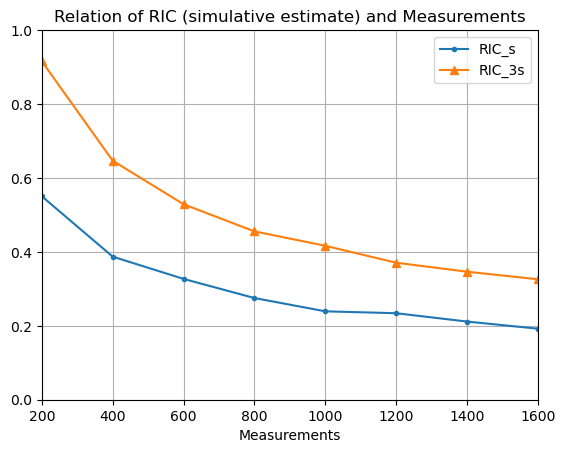

In [32]:
plt.plot(numsMeasurements, RIC_s, '.-', label='RIC_s')
plt.plot(numsMeasurements, RIC_3s, '^-', label='RIC_3s')
plt.ylim((0., 1.0))
plt.xlim((200, 1600))
plt.xlabel('Measurements')
plt.title('Relation of RIC (simulative estimate) and Measurements')
plt.legend()
plt.grid()
plt.show()


In [33]:
# Reconstructions:
priorRatios = [0., 0.2, 0.4, 0.6, 0.8, 1.]  # Total 6.


#### 4.1.1.1 IHT-PKS

In [34]:
def IHTPKS_simulate(X, sampMats, priorRatios, Supps, s=50):
    '''
    description: 
    return {XHat_pR}: \n
    `XHat_pR[i_class(0:5)]` w.r.t. a priorRatio; \n
    `XHat_pR[i_class][i_batch(0:11)]` w.r.t. a sampMatrix; \n
    `XHat_pR[i_class][i_batch][:,j]` j-th signal estimate.
    '''
    XHat_pR = []
    iClass = 0
    for pR in priorRatios:  # Different prior information.
        XHat_m = []
        iBatch = 0
        for Phi in sampMats:  # Different measurements.
            Y = Phi @ X  # Observations.
            XHat = np.zeros(X.shape)
            for j in range(X.shape[1]):  # Different signals.
                y = Y[:, j]
                suppReal = Supps[:, j]
                T0 = suppReal[:int(len(suppReal)*pR)]
                xHat = IHTPKS(y, Phi, s, T0=T0, maxIter=300)
                XHat[:, j] = xHat

            print(
                'One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:', iBatch, sep='')
            iBatch += 1
            XHat_m.append(XHat)
        print(
            'One class of batch `XHat_m` recovered w.r.t. a priorRatio. -> XHat_pR[c],c:', iClass, sep='')
        iClass += 1
        XHat_pR.append(XHat_m)
    return XHat_pR


# XHat_pR_IHTPKS = IHTPKS_simulate(X, sampMats, priorRatios, Supps, s=50)


In [35]:
# # pickleSave:
# pickleSave(XHat_pR_IHTPKS, 'XHat_pR_IHTPKS')

In [36]:
# pickleLoad:
XHat_pR_IHTPKS = pickleLoad('XHat_pR_IHTPKS')

PickleLoad Succeeded. Make sure it's assigned to a variable.


In [37]:
# Quick test:
np.sum(np.abs(XHat_pR_IHTPKS[1][5] - X))

3.2231346696407153

#### 4.1.1.2 OMP-PKS

In [38]:
# Reconstructions:
priorRatios = [0., 0.2, 0.4, 0.6, 0.8, 1.]  # Total 6.


def OMPPKS_simulate(X, sampMats, priorRatios, Supps):
    '''
    description: Does not require sparsity `s`. \n
    return {XHat_pR}: \n
    `XHat_pR[i_class(0:5)]` w.r.t. a priorRatio; \n
    `XHat_pR[i_class][i_batch(0:11)]` w.r.t. a sampMatrix; \n
    `XHat_pR[i_class][i_batch][:,j]` j-th signal estimate.
    '''
    XHat_pR = []
    iClass = 0
    for pR in priorRatios:  # Different prior information.
        XHat_m = []
        iBatch = 0
        for Phi in sampMats:  # Different measurements.
            Y = Phi @ X  # Observations.
            XHat = np.zeros(X.shape)
            for j in range(X.shape[1]):  # Different signals.
                y = Y[:, j]
                suppReal = Supps[:, j]
                T0 = suppReal[:int(len(suppReal)*pR)]
                xHat = OMPPKS(y, Phi, T0=T0, maxIter=300)
                XHat[:, j] = xHat

            print(
                'One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:', iBatch, sep='')
            iBatch += 1
            XHat_m.append(XHat)
        print(
            'One class of batch `XHat_m` recovered w.r.t. a priorRatio. -> XHat_pR[c],c:', iClass, sep='')
        iClass += 1
        XHat_pR.append(XHat_m)
    return XHat_pR


# XHat_pR_OMPPKS = OMPPKS_simulate(X, sampMats, priorRatios, Supps)

In [39]:
# # pickleSave:
# pickleSave(XHat_pR_OMPPKS, 'XHat_pR_OMPPKS')

In [40]:
# pickleLoad:
XHat_pR_OMPPKS = pickleLoad('XHat_pR_OMPPKS')

PickleLoad Succeeded. Make sure it's assigned to a variable.


In [41]:
# Quick test:
np.sum(np.abs(XHat_pR_OMPPKS[1][5] - X))

3.44626989304635

#### 4.1.1.3 CoSaMP-PKS

In [42]:
def CosampPKS_simulate(X, sampMats, priorRatios, Supps, s=50):
    '''
    return {XHat_pR}: \n
    `XHat_pR[i_class(0:5)]` w.r.t. a priorRatio; \n
    `XHat_pR[i_class][i_batch(0:11)]` w.r.t. a sampMatrix; \n
    `XHat_pR[i_class][i_batch][:,j]` j-th signal estimate.
    '''
    XHat_pR = []
    iClass = 0
    for pR in priorRatios:  # Different prior information.
        XHat_m = []
        iBatch = 0
        for Phi in sampMats:  # Different measurements.
            Y = Phi @ X  # Observations.
            XHat = np.zeros(X.shape)
            for j in range(X.shape[1]):  # Different signals.
                y = Y[:, j]
                suppReal = Supps[:, j]
                T0 = suppReal[:int(len(suppReal)*pR)]
                xHat = CosampPKS(y, Phi, s, T0=T0, maxIter=300)
                XHat[:, j] = xHat

            print(
                'One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:', iBatch, sep='')
            iBatch += 1
            XHat_m.append(XHat)
        print(
            'One class of batch `XHat_m` recovered w.r.t. a priorRatio. -> XHat_pR[c],c:', iClass, sep='')
        iClass += 1
        XHat_pR.append(XHat_m)
    return XHat_pR


# XHat_pR_CosampPKS = CosampPKS_simulate(X, sampMats, priorRatios, Supps, s=50)

In [43]:
# # pickleSave:
# pickleSave(XHat_pR_CosampPKS, 'XHat_pR_CosampPKS')

In [44]:
# pickleLoad:
XHat_pR_CosampPKS = pickleLoad('XHat_pR_CosampPKS')

PickleLoad Succeeded. Make sure it's assigned to a variable.


In [45]:
# Quick test:
np.sum(np.abs(XHat_pR_CosampPKS[1][5] - X))

3.2252494295298644

#### 4.1.1.4 RWLS-Sl0-PKS

In [46]:
# RWLSSl0PKS simulate:
def RWLSSl0PKS_simulate(X, sampMats, priorRatios, Supps):
    '''
    description: Does not require sparsity `s`. \n
    return {XHat_pR}: \n
    `XHat_pR[i_class(0:5)]` w.r.t. a priorRatio; \n
    `XHat_pR[i_class][i_batch(0:11)]` w.r.t. a sampMatrix; \n
    `XHat_pR[i_class][i_batch][:,j]` j-th signal estimate.
    '''
    XHat_pR = []
    iClass = 0
    for pR in priorRatios:  # Different prior information.
        XHat_m = []
        iBatch = 0
        for Phi in sampMats:  # Different measurements.
            Y = Phi @ X  # Observations.
            XHat = np.zeros(X.shape)
            for j in range(X.shape[1]):  # Different signals.
                y = Y[:, j]
                suppReal = Supps[:, j]
                T0 = suppReal[:int(len(suppReal)*pR)]
                xHat = RWLSSl0PKS(y, Phi, T0=T0, maxIter=100)
                XHat[:, j] = xHat

            print(
                'One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:', iBatch, sep='')
            iBatch += 1
            XHat_m.append(XHat)
        print(
            'One class of batch `XHat_m` recovered w.r.t. a priorRatio. -> XHat_pR[c],c:', iClass, sep='')
        iClass += 1
        XHat_pR.append(XHat_m)
    return XHat_pR


# XHat_pR_RWLSSl0PKS = RWLSSl0PKS_simulate(X, sampMats, priorRatios, Supps)

In [47]:
# # pickleSave:
# pickleSave(XHat_pR_RWLSSl0PKS, 'XHat_pR_RWLSSl0PKS')

In [48]:
# pickleLoad:
XHat_pR_RWLSSl0PKS = pickleLoad('XHat_pR_RWLSSl0PKS')

PickleLoad Succeeded. Make sure it's assigned to a variable.


In [49]:
# Quick test:
np.sum(np.abs(XHat_pR_RWLSSl0PKS[1][5] - X))

3.276059699328159

#### 4.1.1.5 IRLS-PKS

In [50]:
# IRLSPKS simulate:
def IRLSPKS_simulate(X, sampMats, priorRatios, Supps):
    '''
    description: Does not require sparsity `s`. \n
    return {XHat_pR}: \n
    `XHat_pR[i_class(0:5)]` w.r.t. a priorRatio; \n
    `XHat_pR[i_class][i_batch(0:11)]` w.r.t. a sampMatrix; \n
    `XHat_pR[i_class][i_batch][:,j]` j-th signal estimate.
    '''
    XHat_pR = []
    iClass = 0
    for pR in priorRatios:  # Different prior information.
        XHat_m = []
        iBatch = 0
        for Phi in sampMats:  # Different measurements.
            Y = Phi @ X  # Observations.
            XHat = np.zeros(X.shape)
            for j in range(X.shape[1]):  # Different signals.
                y = Y[:, j]
                suppReal = Supps[:, j]
                T0 = suppReal[:int(len(suppReal)*pR)]
                xHat = IRLSPKS(y, Phi, T0=T0, maxIter=100)
                XHat[:, j] = xHat

            print(
                'One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:', iBatch, sep='')
            iBatch += 1
            XHat_m.append(XHat)
        print(
            'One class of batch `XHat_m` recovered w.r.t. a priorRatio. -> XHat_pR[c],c:', iClass, sep='')
        iClass += 1
        XHat_pR.append(XHat_m)
    return XHat_pR


# XHat_pR_IRLSPKS = IRLSPKS_simulate(X, sampMats, priorRatios, Supps)

In [51]:
# # pickleSave:
# pickleSave(XHat_pR_IRLSPKS, 'XHat_pR_IRLSPKS')

In [52]:
# pickleLoad:
XHat_pR_IRLSPKS = pickleLoad('XHat_pR_IRLSPKS')

PickleLoad Succeeded. Make sure it's assigned to a variable.


#### 4.1.1.6 Modified-CS

In [53]:
# modifiedCS simulate:
def ModCS_simulate(X, sampMats, priorRatios, Supps, lamb=0.01):
    '''
    description: Does not require sparsity `s`. \n
    return {XHat_pR}: \n
    `XHat_pR[i_class(0:5)]` w.r.t. a priorRatio; \n
    `XHat_pR[i_class][i_batch(0:11)]` w.r.t. a sampMatrix; \n
    `XHat_pR[i_class][i_batch][:,j]` j-th signal estimate.
    '''
    XHat_pR = []
    iClass = 0
    for pR in priorRatios:  # Different prior information.
        XHat_m = []
        iBatch = 0
        for Phi in sampMats:  # Different measurements.
            Y = Phi @ X  # Observations.
            XHat = np.zeros(X.shape)
            for j in range(X.shape[1]):  # Different signals.
                y = Y[:, j]
                suppReal = Supps[:, j]
                T0 = suppReal[:int(len(suppReal)*pR)]
                xHat = ModCS(y, Phi, T0=T0, lamb=lamb)
                XHat[:, j] = xHat

            print(
                'One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:', iBatch, sep='')
            iBatch += 1
            XHat_m.append(XHat)
        print(
            'One class of batch `XHat_m` recovered w.r.t. a priorRatio. -> XHat_pR[c],c:', iClass, sep='')
        iClass += 1
        XHat_pR.append(XHat_m)
    return XHat_pR


# XHat_pR_ModCS = ModCS_simulate(X, sampMats, priorRatios, Supps, lamb=0.01)

In [54]:
# # pickleSave:
# pickleSave(XHat_pR_ModCS, 'XHat_pR_ModCS')

In [55]:
# pickleLoad:
XHat_pR_ModCS = pickleLoad('XHat_pR_ModCS')

PickleLoad Succeeded. Make sure it's assigned to a variable.


#### 4.1.1.7 weightedl1

In [56]:
# weightedl1 simulate:
def weightedl1_simulate(X, sampMats, priorRatios, Supps, lamb=0.01):
    '''
    description: Does not require sparsity `s`. \n
    return {XHat_pR}: \n
    `XHat_pR[i_class(0:5)]` w.r.t. a priorRatio; \n
    `XHat_pR[i_class][i_batch(0:11)]` w.r.t. a sampMatrix; \n
    `XHat_pR[i_class][i_batch][:,j]` j-th signal estimate.
    '''
    XHat_pR = []
    iClass = 0
    for pR in priorRatios:  # Different prior information.
        XHat_m = []
        iBatch = 0
        for Phi in sampMats:  # Different measurements.
            Y = Phi @ X  # Observations.
            XHat = np.zeros(X.shape)
            for j in range(X.shape[1]):  # Different signals.
                y = Y[:, j]
                suppReal = Supps[:, j]
                T0 = suppReal[:int(len(suppReal)*pR)]
                xHat = weightedl1(y, Phi, T0=T0, lamb=lamb)
                XHat[:, j] = xHat

            print(
                'One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:', iBatch, sep='')
            iBatch += 1
            XHat_m.append(XHat)
        print(
            'One class of batch `XHat_m` recovered w.r.t. a priorRatio. -> XHat_pR[c],c:', iClass, sep='')
        iClass += 1
        XHat_pR.append(XHat_m)
    return XHat_pR


# XHat_pR_weightedl1 = weightedl1_simulate(X, sampMats, priorRatios, Supps, lamb=0.01)

In [57]:
# # pickleSave:
# pickleSave(XHat_pR_weightedl1, 'XHat_pR_weightedl1')

In [58]:
# pickleLoad:
XHat_pR_weightedl1 = pickleLoad('XHat_pR_weightedl1')

PickleLoad Succeeded. Make sure it's assigned to a variable.


#### 4.1.1.8 reweightedl1

In [59]:
# reweightedl1 simulate:
def reweightedl1_simulate(X, sampMats, priorRatios, Supps, lamb=0.02):
    '''
    description: Does not require sparsity `s`. \n
    return {XHat_pR}: \n
    `XHat_pR[i_class(0:5)]` w.r.t. a priorRatio; \n
    `XHat_pR[i_class][i_batch(0:11)]` w.r.t. a sampMatrix; \n
    `XHat_pR[i_class][i_batch][:,j]` j-th signal estimate.
    '''
    XHat_pR = []
    iClass = 0
    for pR in priorRatios:  # Different prior information.
        XHat_m = []
        iBatch = 0
        for Phi in sampMats:  # Different measurements.
            Y = Phi @ X  # Observations.
            XHat = np.zeros(X.shape)
            for j in range(X.shape[1]):  # Different signals.
                y = Y[:, j]
                suppReal = Supps[:, j]
                T0 = suppReal[:int(len(suppReal)*pR)]
                xHat = reweightedl1(y, Phi, T0=T0, lamb=lamb, maxIter=5)
                XHat[:, j] = xHat

            print(
                'One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:', iBatch, sep='')
            iBatch += 1
            XHat_m.append(XHat)
        print(
            'One class of batch `XHat_m` recovered w.r.t. a priorRatio. -> XHat_pR[c],c:', iClass, sep='')
        iClass += 1
        XHat_pR.append(XHat_m)
    return XHat_pR


# XHat_pR_reweightedl1 = reweightedl1_simulate(X, sampMats, priorRatios, Supps, lamb=0.02)

In [60]:
# # pickleSave:
# pickleSave(XHat_pR_reweightedl1, 'XHat_pR_reweightedl1')

In [61]:
# pickleLoad:
XHat_pR_reweightedl1 = pickleLoad('XHat_pR_reweightedl1')

PickleLoad Succeeded. Make sure it's assigned to a variable.


#### 4.1.1.9 reg-mod-BPDN

In [62]:
# regModBPDN simulate:
def regModBPDN_simulate(X, sampMats, priorRatios, Supps, lamb=0.01):
    '''
    description: Does not require sparsity `s`. \n
    return {XHat_pR}: \n
    `XHat_pR[i_class(0:5)]` w.r.t. a priorRatio; \n
    `XHat_pR[i_class][i_batch(0:11)]` w.r.t. a sampMatrix; \n
    `XHat_pR[i_class][i_batch][:,j]` j-th signal estimate.
    '''
    np.random.seed(42)

    XHat_pR = []
    iClass = 0
    for pR in priorRatios:  # Different prior information.
        XHat_m = []
        iBatch = 0
        for Phi in sampMats:  # Different measurements.
            Y = Phi @ X  # Observations.
            XHat = np.zeros(X.shape)
            for j in range(X.shape[1]):  # Different signals.
                y = Y[:, j]
                suppReal = Supps[:, j]
                T0 = suppReal[:int(len(suppReal)*pR)]
                # x is known:
                x0 = Means[:, j]
                xHat = regModBPDN(y, Phi, T0=T0, lamb=lamb, x0=x0)
                XHat[:, j] = xHat

            print(
                'One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:', iBatch, sep='')
            iBatch += 1
            XHat_m.append(XHat)
        print(
            'One class of batch `XHat_m` recovered w.r.t. a priorRatio. -> XHat_pR[c],c:', iClass, sep='')
        iClass += 1
        XHat_pR.append(XHat_m)
    return XHat_pR


# XHat_pR_regModBPDN = regModBPDN_simulate(
#     X, sampMats, priorRatios, Supps, lamb=0.01)


In [63]:
# # pickleSave:
# pickleSave(XHat_pR_regModBPDN, 'XHat_pR_regModBPDN')

In [64]:
# pickleLoad:
XHat_pR_regModBPDN = pickleLoad('XHat_pR_regModBPDN')

PickleLoad Succeeded. Make sure it's assigned to a variable.


### 4.1.2 Running time of SCS w.r.t. n, m/RIC, s, pR

In [30]:
import time

#### 4.1.2.1 RunningTime ~ n
m = 300, s = 50, pR = 0.6
n = 1000,...,20000

In [66]:
m = 300
s = 50
pR = 0.6

nPoolLong = np.array([400,500,700,900,1100,1500,2000,4000,6000]) # We use a Long version for betterization.
sampMats_nLong = []
for j in range(len(nPoolLong)):
    sampMats_nLong.append(randSampMat(m,nPoolLong[j]))
X_nLong = []
Supps_nLong = []
for j in range(len(nPoolLong)):
    _ = randSparseSignal(nPoolLong[j],s,1,True)
    X_nLong.append(_['Signals'][:,0])
    Supps_nLong.append(_['Supports'][:,0])

pickleSave(nPoolLong,'nPoolLong')
pickleSave(sampMats_nLong,'sampMats_nLong')
pickleSave(X_nLong,'X_nLong')
pickleSave(Supps_nLong,'Supps_nLong')


PickleSave Succeeded.
PickleSave Succeeded.
PickleSave Succeeded.
PickleSave Succeeded.


In [178]:
nPoolLong=pickleLoad('nPoolLong')
sampMats_nLong=pickleLoad('sampMats_nLong')
X_nLong=pickleLoad('X_nLong')
Supps_nLong=pickleLoad('Supps_nLong')

PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.


##### 4.1.2.1.1 IHT-PKS

In [67]:
# runningTimes = []
# for j in range(len(nPoolLong)):
#     x = X_nLong[j]
#     supp = Supps_nLong[j]
#     Phi = sampMats_nLong[j]
#     y = Phi @ x
#     start = time.time()
#     IHTPKS(y, Phi, s, T0=supp[:int(len(supp)*pR)])
#     end = time.time()
#     delta = end - start
#     runningTimes.append(delta)

# pickleSave(runningTimes,'runningTimes_n_IHTPKS')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


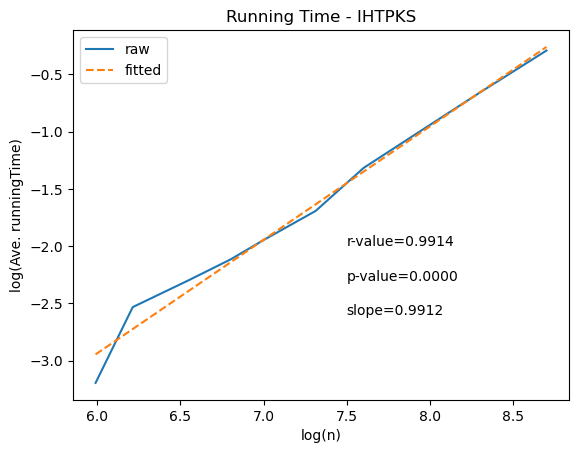

In [70]:
runningTimes_n_IHTPKS = pickleLoad('runningTimes_n_IHTPKS')
plt.plot(np.log(nPoolLong),np.log(runningTimes_n_IHTPKS),label='raw')
plt.xlabel('log(n)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - IHTPKS')

nPool = np.array(nPoolLong)
result = stats.linregress(np.log(nPoolLong),np.log(runningTimes_n_IHTPKS))
plt.plot(np.log(nPoolLong), result.intercept + result.slope * np.log(nPoolLong), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(7.5,-2))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(7.5,-2.3))
plt.annotate('slope='+"{:.4f}".format(result.slope),(7.5,-2.6))
plt.show()

##### 4.1.2.1.2 OMP-PKS

In [71]:
# runningTimes = []
# for j in range(len(nPoolLong)):
#     x = X_nLong[j]
#     supp = Supps_nLong[j]
#     Phi = sampMats_nLong[j]
#     y = Phi @ x
#     start = time.time()
#     OMPPKS(y, Phi, T0=supp[:int(len(supp)*pR)])
#     end = time.time()
#     delta = end - start
#     runningTimes.append(delta)

# pickleSave(runningTimes,'runningTimes_n_OMPPKS')

PickleSave Succeeded.


In [72]:
runningTimes_n_OMPPKS = pickleLoad('runningTimes_n_OMPPKS')

PickleLoad Succeeded. Make sure it's assigned to a variable.


PickleLoad Succeeded. Make sure it's assigned to a variable.


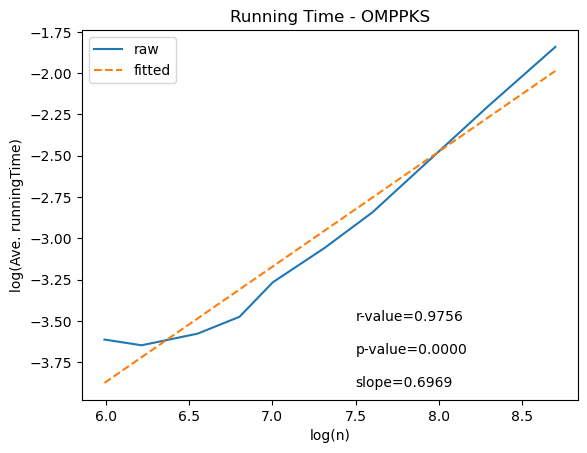

In [76]:
runningTimes_n_OMPPKS = pickleLoad('runningTimes_n_OMPPKS')

plt.plot(np.log(nPoolLong),np.log(runningTimes_n_OMPPKS),label='raw')
plt.xlabel('log(n)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - OMPPKS')

nPool = np.array(nPoolLong)
result = stats.linregress(np.log(nPoolLong),np.log(runningTimes_n_OMPPKS))
plt.plot(np.log(nPoolLong), result.intercept + result.slope * np.log(nPoolLong), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(7.5,-3.5))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(7.5,-3.7))
plt.annotate('slope='+"{:.4f}".format(result.slope),(7.5,-3.9))
plt.show()



##### 4.1.2.1.3 CoSaMP-PKS

In [77]:
# runningTimes = []
# for j in range(len(nPoolLong)):
#     x = X_nLong[j]
#     supp = Supps_nLong[j]
#     Phi = sampMats_nLong[j]
#     y = Phi @ x
#     start = time.time()
#     CosampPKS(y, Phi, s, T0=supp[:int(len(supp)*pR)])
#     end = time.time()
#     delta += end - start
#     runningTimes.append(delta)

# pickleSave(runningTimes,'runningTimes_n_CosampPKS')

PickleSave Succeeded.


In [78]:
runningTimes_n_CosampPKS = pickleLoad('runningTimes_n_CosampPKS')

PickleLoad Succeeded. Make sure it's assigned to a variable.


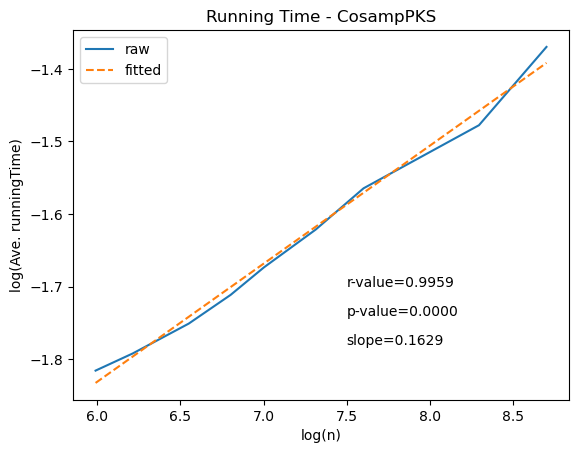

In [81]:
plt.plot(np.log(nPoolLong),np.log(runningTimes_n_CosampPKS),label='raw')
plt.xlabel('log(n)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - CosampPKS')

result = stats.linregress(np.log(nPoolLong),np.log(runningTimes_n_CosampPKS))
plt.plot(np.log(nPoolLong), result.intercept + result.slope * np.log(nPoolLong), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(7.5,-1.7))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(7.5,-1.74))
plt.annotate('slope='+"{:.4f}".format(result.slope),(7.5,-1.78))

plt.show()

##### 4.1.2.1.4 RWLS-Sl0-PKS

In [112]:
# nPoolLong=pickleLoad('nPoolLong')
# sampMats_nLong=pickleLoad('sampMats_nLong')
# X_nLong=pickleLoad('X_nLong')
# Supps_nLong=pickleLoad('Supps_nLong')

PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.


In [82]:
# runningTimes = []
# for j in range(len(nPoolLong)):
#     x = X_nLong[j]
#     supp = Supps_nLong[j]
#     Phi = sampMats_nLong[j]
#     y = Phi @ x
#     start = time.time()
#     RWLSSl0PKS(y, Phi, T0=supp[:int(len(supp)*pR)],maxIter=100,showIfMaxIter=True)
#     end = time.time()
#     delta = end - start
#     runningTimes.append(delta)

# runningTimes_n_RWLSSl0PKS = runningTimes

# pickleSave(runningTimes,'runningTimes_n_RWLSSl0PKS')

PickleSave Succeeded.


In [83]:
runningTimes_n_RWLSSl0PKS = pickleLoad('runningTimes_n_RWLSSl0PKS')

PickleLoad Succeeded. Make sure it's assigned to a variable.


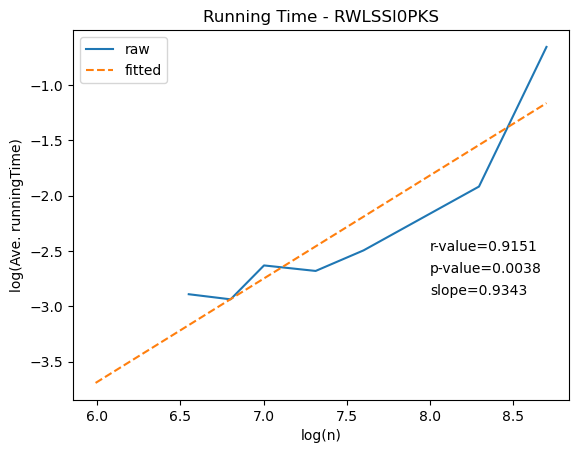

In [87]:
plt.plot(np.log(nPoolLong[2:]),np.log(runningTimes_n_RWLSSl0PKS[2:]),label='raw')
plt.xlabel('log(n)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - RWLSSl0PKS')

result = stats.linregress(np.log(nPoolLong[2:]),np.log(runningTimes_n_RWLSSl0PKS[2:]))
plt.plot(np.log(nPoolLong), result.intercept + result.slope * np.log(nPoolLong), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(8,-2.5))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(8,-2.7))
plt.annotate('slope='+"{:.4f}".format(result.slope),(8,-2.9))

plt.show()

##### 4.1.2.1.5 IRLS-PKS

In [88]:
# runningTimes = []
# for j in range(len(nPoolLong)):
#     x = X_nLong[j]
#     supp = Supps_nLong[j]
#     Phi = sampMats_nLong[j]
#     y = Phi @ x
#     start = time.time()
#     IRLSPKS(y, Phi, T0=supp[:int(len(supp)*pR)],maxIter=1000,showIfMaxIter=True)
#     end = time.time()
#     delta = end - start
#     runningTimes.append(delta)

# pickleSave(runningTimes,'runningTimes_n_IRLSPKS')

PickleSave Succeeded.


In [89]:
runningTimes_n_IRLSPKS = pickleLoad('runningTimes_n_IRLSPKS')

PickleLoad Succeeded. Make sure it's assigned to a variable.


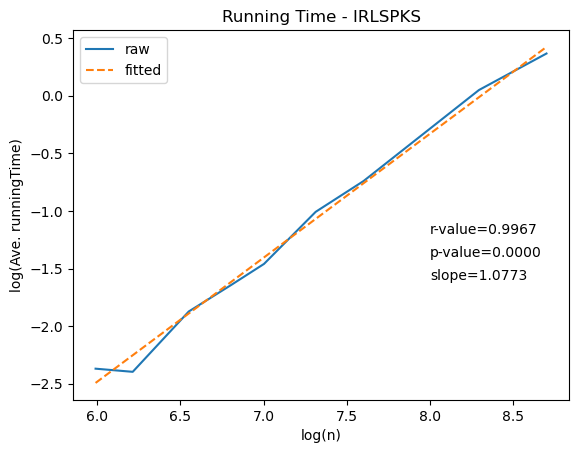

In [90]:
plt.plot(np.log(nPoolLong),np.log(runningTimes_n_IRLSPKS),label='raw')
plt.xlabel('log(n)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - IRLSPKS')

result = stats.linregress(np.log(nPoolLong),np.log(runningTimes_n_IRLSPKS))
plt.plot(np.log(nPoolLong), result.intercept + result.slope * np.log(nPoolLong), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(8,-1.2))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(8,-1.4))
plt.annotate('slope='+"{:.4f}".format(result.slope),(8,-1.6))
plt.show()

##### 4.1.2.1.6 ModCS

In [91]:
# runningTimes = []
# for j in range(len(nPoolLong)):
#     x = X_nLong[j]
#     supp = Supps_nLong[j]
#     Phi = sampMats_nLong[j]
#     y = Phi @ x
#     start = time.time()
#     ModCS(y, Phi, T0=supp[:int(len(supp)*pR)])
#     end = time.time()
#     delta = end - start
#     runningTimes.append(delta)

# pickleSave(runningTimes,'runningTimes_n_ModCS')

     pcost       dcost       gap    pres   dres   k/t
 0: -9.5132e-15 -8.0000e+01  3e+03  4e+00  1e+00  1e+00
 1: -1.1631e+01 -2.4147e+01  3e+02  7e-01  2e-01  9e-01
 2:  2.5011e+00 -3.2702e+00  1e+02  3e-01  8e-02  4e-01
 3:  1.3161e+01  1.2278e+01  1e+01  5e-02  1e-02  3e-02
 4:  1.5992e+01  1.5739e+01  4e+00  1e-02  3e-03  7e-03
 5:  1.6690e+01  1.6585e+01  2e+00  5e-03  1e-03  3e-03
 6:  1.6993e+01  1.6951e+01  6e-01  2e-03  6e-04  7e-04
 7:  1.7141e+01  1.7126e+01  2e-01  7e-04  2e-04  2e-04
 8:  1.7187e+01  1.7181e+01  9e-02  3e-04  8e-05  9e-05
 9:  1.7216e+01  1.7215e+01  2e-02  5e-05  1e-05  1e-05
10:  1.7220e+01  1.7219e+01  5e-03  2e-05  4e-06  4e-06
11:  1.7221e+01  1.7221e+01  1e-03  4e-06  9e-07  7e-07
12:  1.7222e+01  1.7222e+01  2e-05  7e-08  2e-08  1e-08
13:  1.7222e+01  1.7222e+01  2e-07  7e-10  2e-10  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.4980e-16 -1.0000e+02  4e+03  4e+00  1e+00  1e+00
 1: -1.6683e+01 -3.2837e+01 

In [92]:
runningTimes_n_ModCS = pickleLoad('runningTimes_n_ModCS')

PickleLoad Succeeded. Make sure it's assigned to a variable.


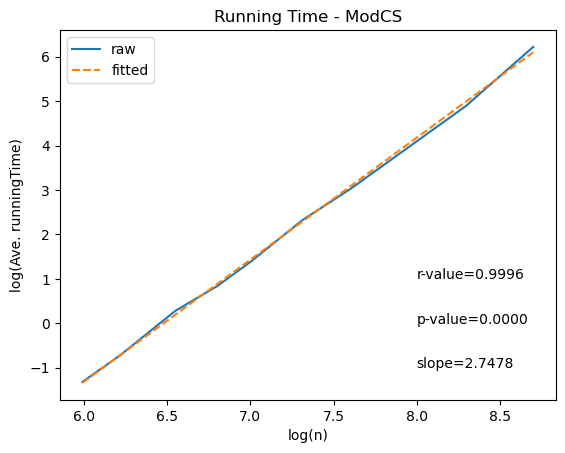

In [93]:
plt.plot(np.log(nPoolLong),np.log(runningTimes_n_ModCS),label='raw')
plt.xlabel('log(n)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - ModCS')

result = stats.linregress(np.log(nPoolLong),np.log(runningTimes_n_ModCS))
plt.plot(np.log(nPoolLong), result.intercept + result.slope * np.log(nPoolLong), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(8,1))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(8,0))
plt.annotate('slope='+"{:.4f}".format(result.slope),(8,-1))
plt.show()

##### 4.1.2.1.7 weightedl1

In [94]:
# runningTimes = []
# for j in range(len(nPoolLong)):
#     x = X_nLong[j]
#     supp = Supps_nLong[j]
#     Phi = sampMats_nLong[j]
#     y = Phi @ x
#     start = time.time()
#     weightedl1(y, Phi, T0=supp[:int(len(supp)*pR)])
#     end = time.time()
#     delta = end - start
#     runningTimes.append(delta)

# pickleSave(runningTimes,'runningTimes_n_weightedl1')

     pcost       dcost       gap    pres   dres   k/t
 0: -9.8671e-15 -8.0000e+01  3e+03  4e+00  1e+00  1e+00
 1: -1.1432e+01 -2.3798e+01  3e+02  7e-01  2e-01  9e-01
 2:  2.7313e+00 -3.0400e+00  1e+02  3e-01  8e-02  4e-01
 3:  1.3453e+01  1.2555e+01  1e+01  5e-02  1e-02  3e-02
 4:  1.6199e+01  1.5924e+01  4e+00  1e-02  4e-03  8e-03
 5:  1.6973e+01  1.6866e+01  2e+00  5e-03  1e-03  3e-03
 6:  1.7291e+01  1.7251e+01  6e-01  2e-03  5e-04  7e-04
 7:  1.7436e+01  1.7424e+01  2e-01  7e-04  2e-04  2e-04
 8:  1.7495e+01  1.7493e+01  3e-02  1e-04  3e-05  3e-05
 9:  1.7504e+01  1.7503e+01  6e-03  2e-05  5e-06  4e-06
10:  1.7506e+01  1.7506e+01  8e-05  3e-07  7e-08  6e-08
11:  1.7506e+01  1.7506e+01  8e-07  3e-09  7e-10  6e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  3.0531e-16 -1.0000e+02  4e+03  4e+00  1e+00  1e+00
 1: -1.6512e+01 -3.2409e+01  4e+02  6e-01  2e-01  9e-01
 2: -1.7882e+00 -9.5199e+00  2e+02  3e-01  8e-02  4e-01
 3:  7.1426e+00  3.6877e+00 

In [95]:
runningTimes_n_weightedl1 = pickleLoad('runningTimes_n_weightedl1')

PickleLoad Succeeded. Make sure it's assigned to a variable.


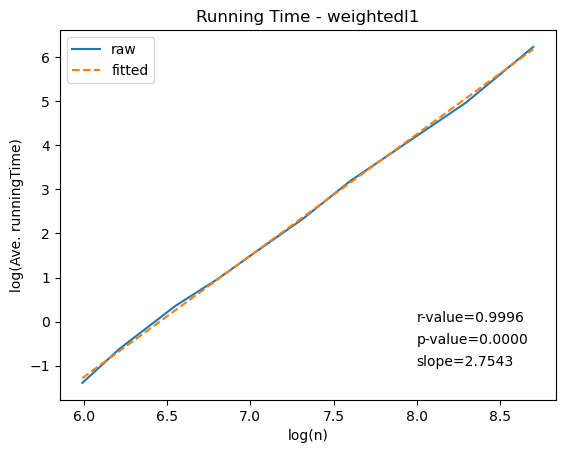

In [96]:
plt.plot(np.log(nPoolLong),np.log(runningTimes_n_weightedl1),label='raw')
plt.xlabel('log(n)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - weightedl1')

result = stats.linregress(np.log(nPoolLong),np.log(runningTimes_n_weightedl1))
plt.plot(np.log(nPoolLong), result.intercept + result.slope * np.log(nPoolLong), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(8,0))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(8,-0.5))
plt.annotate('slope='+"{:.4f}".format(result.slope),(8,-1))
plt.show()

##### 4.1.2.1.8 reweightedl1

In [97]:
# runningTimes = []
# for j in range(len(nPoolLong)):
#     x = X_nLong[j]
#     supp = Supps_nLong[j]
#     Phi = sampMats_nLong[j]
#     y = Phi @ x
#     start = time.time()
#     reweightedl1(y, Phi, T0=supp[:int(len(supp)*pR)])
#     end = time.time()
#     delta = end - start
#     runningTimes.append(delta)

# pickleSave(runningTimes,'runningTimes_n_reweightedl1')

     pcost       dcost       gap    pres   dres   k/t
 0: -9.9685e-12 -8.0000e+01  1e+06  4e+00  1e-03  1e+00
 1: -2.2652e+03 -2.2565e+03  5e+05  2e+00  5e-04  5e+01
 2: -2.5377e+03 -2.4778e+03  6e+05  2e+00  5e-04  1e+02
 3: -6.5822e+03 -6.4669e+03  4e+05  1e+00  3e-04  1e+02
 4:  4.1772e+03  4.2163e+03  1e+05  4e-01  1e-04  5e+01
 5:  1.0561e+04  1.0582e+04  5e+04  2e-01  5e-05  3e+01
 6:  1.8219e+04  1.8221e+04  6e+03  2e-02  6e-06  3e+00
 7:  1.9321e+04  1.9322e+04  2e+03  7e-03  2e-06  1e+00
 8:  1.9602e+04  1.9603e+04  1e+03  4e-03  1e-06  6e-01
 9:  1.9870e+04  1.9870e+04  4e+02  2e-03  4e-07  2e-01
10:  1.9942e+04  1.9942e+04  2e+02  7e-04  2e-07  1e-01
11:  2.0024e+04  2.0024e+04  2e+01  9e-05  2e-08  1e-02
12:  2.0029e+04  2.0029e+04  1e+01  5e-05  1e-08  8e-03
13:  2.0031e+04  2.0031e+04  9e+00  3e-05  8e-09  5e-03
14:  2.0034e+04  2.0034e+04  1e+00  4e-06  1e-09  7e-04
15:  2.0035e+04  2.0035e+04  4e-02  2e-07  4e-11  3e-05
16:  2.0035e+04  2.0035e+04  4e-04  2e-09  4e-13  

In [98]:
runningTimes_n_reweightedl1 = pickleLoad('runningTimes_n_reweightedl1')

PickleLoad Succeeded. Make sure it's assigned to a variable.


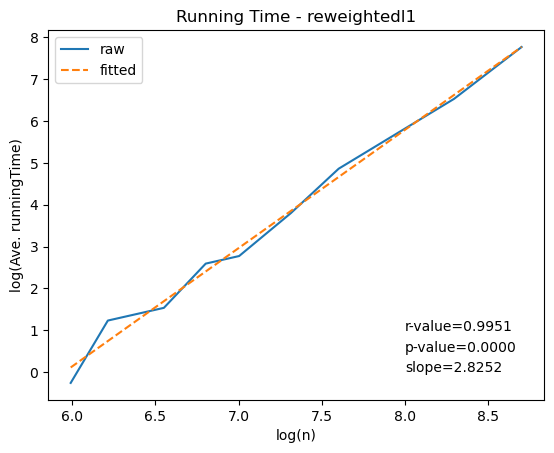

In [103]:
plt.plot(np.log(nPoolLong),np.log(runningTimes_n_reweightedl1),label='raw')
plt.xlabel('log(n)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - reweightedl1')

result = stats.linregress(np.log(nPoolLong),np.log(runningTimes_n_reweightedl1))
plt.plot(np.log(nPoolLong), result.intercept + result.slope * np.log(nPoolLong), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(8,1))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(8,0.5))
plt.annotate('slope='+"{:.4f}".format(result.slope),(8,0))
plt.show()

##### 4.1.2.1.9 reg-mod-BPDN

In [100]:
# runningTimes = []
# for j in range(len(nPoolLong)):
#     x = X_nLong[j]
#     supp = Supps_nLong[j]
#     Phi = sampMats_nLong[j]
#     y = Phi @ x
#     start = time.time()
#     regModBPDN(y, Phi, T0=supp[:int(len(supp)*pR)], x0=x)
#     end = time.time()
#     delta = end - start
#     runningTimes.append(delta)

# pickleSave(runningTimes,'runningTimes_n_regModBPDN')

     pcost       dcost       gap    pres   dres
 0: -7.7473e+02  1.0118e+03  2e+03  6e+01  1e+00
 1:  2.8975e+02 -4.3177e+01  4e+02  1e+00  2e-02
 2: -1.3299e+00 -2.9076e+01  3e+01  9e-02  2e-03
 3: -2.5858e+01 -2.7219e+01  1e+00  2e-03  4e-05
 4: -2.7046e+01 -2.7101e+01  6e-02  6e-05  1e-06
 5: -2.7093e+01 -2.7095e+01  1e-03  7e-07  1e-08
 6: -2.7094e+01 -2.7094e+01  2e-05  8e-09  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.7624e+02  1.2858e+03  3e+03  7e+01  1e+00
 1:  3.6519e+02 -4.7654e+01  5e+02  1e+00  2e-02
 2:  7.0239e+00 -3.1172e+01  4e+01  1e-01  2e-03
 3: -2.4751e+01 -2.9409e+01  5e+00  1e-02  2e-04
 4: -2.9096e+01 -2.9248e+01  2e-01  3e-04  5e-06
 5: -2.9238e+01 -2.9240e+01  3e-03  4e-06  6e-08
 6: -2.9240e+01 -2.9240e+01  4e-05  4e-08  7e-10
 7: -2.9240e+01 -2.9240e+01  4e-07  4e-10  7e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.3809e+03  1.8412e+03  4e+03  8e+01  1e+00
 1:  4.9759e+02 -5.8592e

In [101]:
runningTimes_n_regModBPDN = pickleLoad('runningTimes_n_regModBPDN')

PickleLoad Succeeded. Make sure it's assigned to a variable.


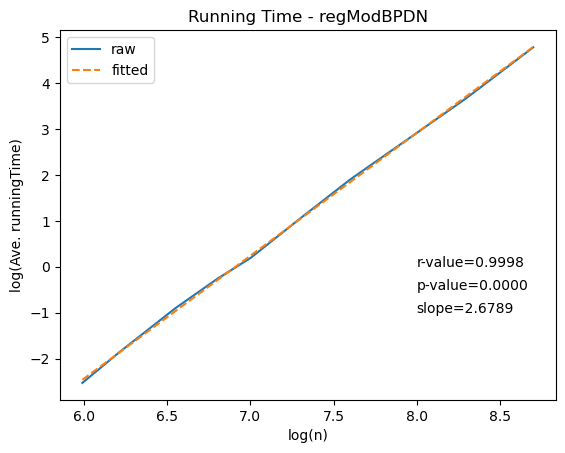

In [102]:
plt.plot(np.log(nPoolLong),np.log(runningTimes_n_regModBPDN),label='raw')
plt.xlabel('log(n)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - regModBPDN')

result = stats.linregress(np.log(nPoolLong),np.log(runningTimes_n_regModBPDN))
plt.plot(np.log(nPoolLong), result.intercept + result.slope * np.log(nPoolLong), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(8,0))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(8,-0.5))
plt.annotate('slope='+"{:.4f}".format(result.slope),(8,-1))
plt.show()

#### 4.1.2.2 RunningTime ~ m

In [31]:
n = 3000
s = 50
pR = 0.6
# mPool = np.array([800,900,1000,1200,1400,1600,2000,2300,2600,2800])

# sampMats_m = []
# for j in range(len(mPool)):
#     sampMats_m.append(randSampMat(mPool[j],n))
# xx = randSparseSignal(n,s,1,True)
# x_m = xx["Signals"][:,0]
# supp_m = xx["Supports"][:,0]
# del xx

# pickleSave(mPool,'mPool')
# pickleSave(sampMats_m,'sampMats_m')
# pickleSave(x_m,'x_m')
# pickleSave(supp_m,'supp_m')

PickleSave Succeeded.
PickleSave Succeeded.
PickleSave Succeeded.
PickleSave Succeeded.


In [32]:
mPool=pickleLoad('mPool')
sampMats_m=pickleLoad('sampMats_m')
x_m=pickleLoad('x_m')
supp_m=pickleLoad('supp_m')

PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.


##### 4.1.2.2.1 IHT-PKS

In [216]:
runningTimes = []
for j in range(len(mPool)):
    Phi = sampMats_m[j]
    y = Phi @ x_m
    start = time.time()
    IHTPKS(y, Phi, s, T0=supp_m[:int(len(supp_m)*pR)],showIfMaxIter=True)
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_m_IHTPKS')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


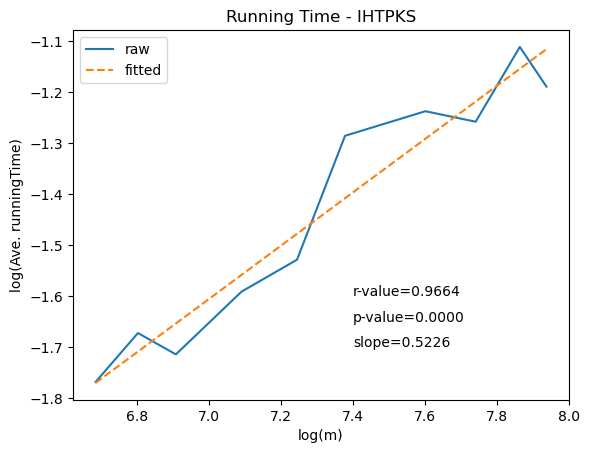

In [212]:
runningTimes_m_IHTPKS = pickleLoad('runningTimes_m_IHTPKS')

plt.plot(np.log(mPool),np.log(runningTimes_m_IHTPKS),label='raw')
plt.xlabel('log(m)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - IHTPKS')

result = stats.linregress(np.log(mPool),np.log(runningTimes_m_IHTPKS))
plt.plot(np.log(mPool), result.intercept + result.slope * np.log(mPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(7.4,-1.6))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(7.4,-1.65))
plt.annotate('slope='+"{:.4f}".format(result.slope),(7.4,-1.7))
plt.show()

##### 4.1.2.2.2 OMP-PKS

In [213]:
runningTimes = []
for j in range(len(mPool)):
    Phi = sampMats_m[j]
    y = Phi @ x_m
    start = time.time()
    OMPPKS(y, Phi, T0=supp_m[:int(len(supp_m)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_m_OMPPKS')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


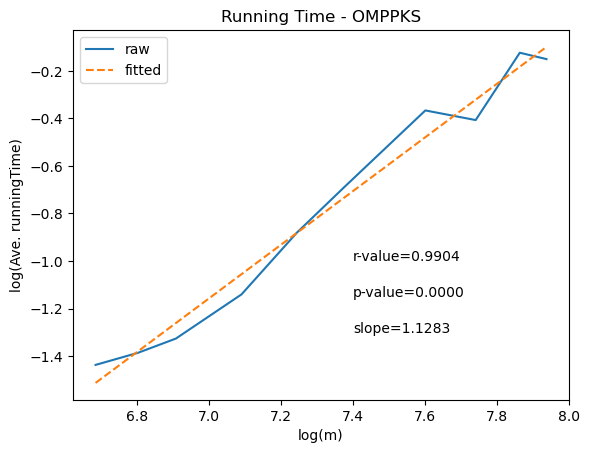

In [214]:
runningTimes_m_OMPPKS = pickleLoad('runningTimes_m_OMPPKS')

plt.plot(np.log(mPool),np.log(runningTimes_m_OMPPKS),label='raw')
plt.xlabel('log(m)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - OMPPKS')

result = stats.linregress(np.log(mPool),np.log(runningTimes_m_OMPPKS))
plt.plot(np.log(mPool), result.intercept + result.slope * np.log(mPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(7.4,-1))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(7.4,-1.15))
plt.annotate('slope='+"{:.4f}".format(result.slope),(7.4,-1.3))
plt.show()

##### 4.1.2.2.3 CosampPKS

In [217]:
runningTimes = []
for j in range(len(mPool)):
    Phi = sampMats_m[j]
    y = Phi @ x_m
    start = time.time()
    CosampPKS(y, Phi, s, T0=supp_m[:int(len(supp_m)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_m_CosampPKS')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


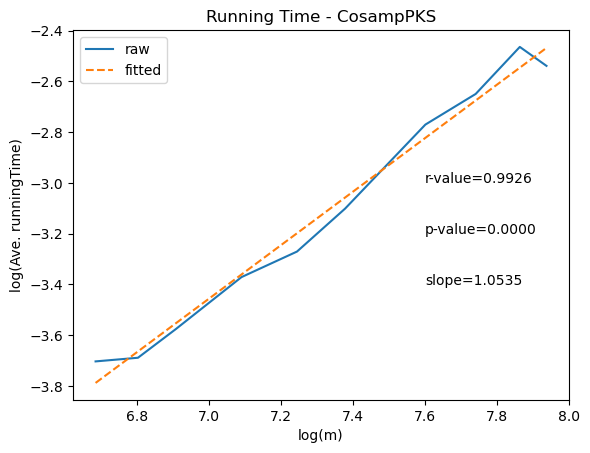

In [219]:
runningTimes_m_CosampPKS = pickleLoad('runningTimes_m_CosampPKS')

plt.plot(np.log(mPool),np.log(runningTimes_m_CosampPKS),label='raw')
plt.xlabel('log(m)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - CosampPKS')

result = stats.linregress(np.log(mPool),np.log(runningTimes_m_CosampPKS))
plt.plot(np.log(mPool), result.intercept + result.slope * np.log(mPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(7.6,-3))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(7.6,-3.2))
plt.annotate('slope='+"{:.4f}".format(result.slope),(7.6,-3.4))
plt.show()

##### 4.1.2.2.4 RWLSSl0PKS

In [220]:
runningTimes = []
for j in range(len(mPool)):
    Phi = sampMats_m[j]
    y = Phi @ x_m
    start = time.time()
    RWLSSl0PKS(y, Phi, T0=supp_m[:int(len(supp_m)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_m_RWLSSl0PKS')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


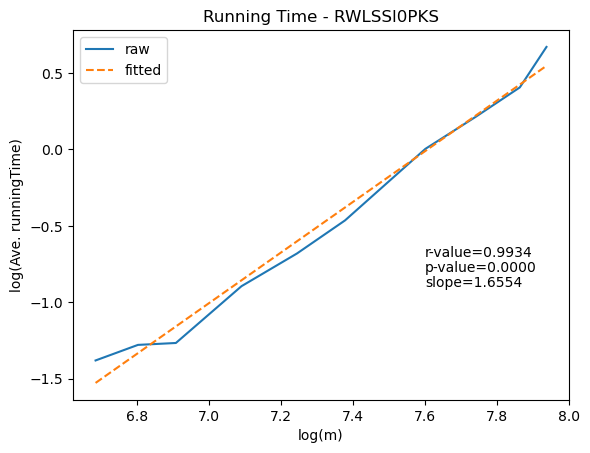

In [222]:
runningTimes_m_RWLSSl0PKS = pickleLoad('runningTimes_m_RWLSSl0PKS')

plt.plot(np.log(mPool),np.log(runningTimes_m_RWLSSl0PKS),label='raw')
plt.xlabel('log(m)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - RWLSSl0PKS')

result = stats.linregress(np.log(mPool),np.log(runningTimes_m_RWLSSl0PKS))
plt.plot(np.log(mPool), result.intercept + result.slope * np.log(mPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(7.6,-0.7))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(7.6,-0.8))
plt.annotate('slope='+"{:.4f}".format(result.slope),(7.6,-0.9))
plt.show()

##### 4.1.2.2.5 IRLSPKS

In [223]:
runningTimes = []
for j in range(len(mPool)):
    Phi = sampMats_m[j]
    y = Phi @ x_m
    start = time.time()
    IRLSPKS(y, Phi, T0=supp_m[:int(len(supp_m)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_m_IRLSPKS')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


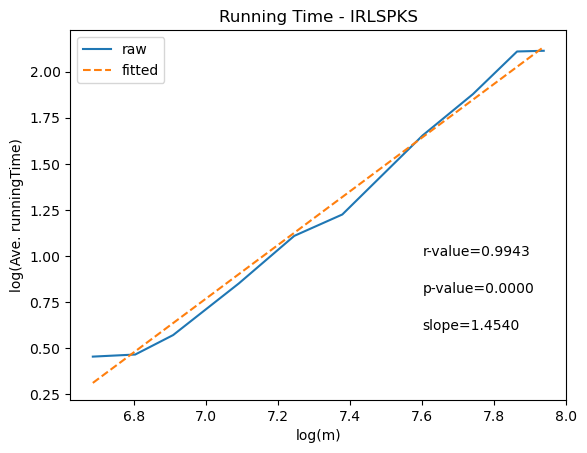

In [225]:
runningTimes_m_IRLSPKS = pickleLoad('runningTimes_m_IRLSPKS')

plt.plot(np.log(mPool),np.log(runningTimes_m_IRLSPKS),label='raw')
plt.xlabel('log(m)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - IRLSPKS')

result = stats.linregress(np.log(mPool),np.log(runningTimes_m_IRLSPKS))
plt.plot(np.log(mPool), result.intercept + result.slope * np.log(mPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(7.6,1))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(7.6,0.8))
plt.annotate('slope='+"{:.4f}".format(result.slope),(7.6,0.6))
plt.show()

##### 4.1.2.2.6 ModCS


In [226]:
runningTimes = []
for j in range(len(mPool)):
    Phi = sampMats_m[j]
    y = Phi @ x_m
    start = time.time()
    ModCS(y, Phi, T0=supp_m[:int(len(supp_m)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_m_ModCS')

     pcost       dcost       gap    pres   dres   k/t
 0: -2.3981e-14 -6.0000e+02  2e+04  6e+00  1e+00  1e+00
 1: -1.4797e+02 -2.6742e+02  2e+03  1e+00  2e-01  8e-01
 2: -8.8078e+01 -1.4210e+02  9e+02  5e-01  9e-02  4e-01
 3: -4.4748e+01 -7.0762e+01  4e+02  2e-01  4e-02  2e-01
 4: -9.8037e-01 -7.4182e+00  9e+01  6e-02  1e-02  4e-02
 5:  8.9704e+00  6.0921e+00  4e+01  3e-02  5e-03  2e-02
 6:  1.1494e+01  9.7993e+00  2e+01  2e-02  3e-03  8e-03
 7:  1.4418e+01  1.3650e+01  1e+01  7e-03  1e-03  3e-03
 8:  1.5746e+01  1.5335e+01  5e+00  4e-03  7e-04  1e-03
 9:  1.6655e+01  1.6471e+01  2e+00  2e-03  3e-04  5e-04
10:  1.7057e+01  1.6968e+01  1e+00  8e-04  1e-04  2e-04
11:  1.7328e+01  1.7299e+01  4e-01  3e-04  5e-05  5e-05
12:  1.7427e+01  1.7418e+01  1e-01  8e-05  1e-05  9e-06
13:  1.7470e+01  1.7469e+01  2e-03  1e-06  2e-07  2e-07
14:  1.7470e+01  1.7470e+01  2e-05  1e-08  2e-09  2e-09
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres   k/t
 0: -2.2204e-16 -6

PickleLoad Succeeded. Make sure it's assigned to a variable.


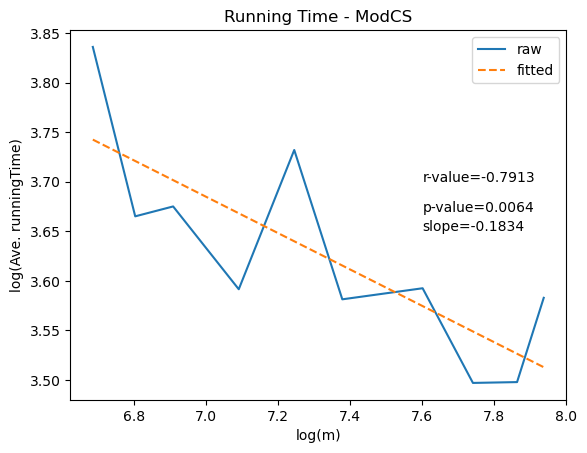

In [236]:
runningTimes_m_ModCS = pickleLoad('runningTimes_m_ModCS')

plt.plot(np.log(mPool),np.log(runningTimes_m_ModCS),label='raw')
plt.xlabel('log(m)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - ModCS')

result = stats.linregress(np.log(mPool),np.log(runningTimes_m_ModCS))
plt.plot(np.log(mPool), result.intercept + result.slope * np.log(mPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(7.6,3.7))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(7.6,3.67))
plt.annotate('slope='+"{:.4f}".format(result.slope),(7.6,3.65))
plt.show()

##### 4.1.2.2.7 weightedl1


In [228]:
runningTimes = []
for j in range(len(mPool)):
    Phi = sampMats_m[j]
    y = Phi @ x_m
    start = time.time()
    weightedl1(y, Phi, T0=supp_m[:int(len(supp_m)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_m_weightedl1')

     pcost       dcost       gap    pres   dres   k/t
 0: -2.3537e-14 -6.0000e+02  2e+04  6e+00  1e+00  1e+00
 1: -1.4852e+02 -2.6564e+02  2e+03  1e+00  2e-01  8e-01
 2: -8.7709e+01 -1.4124e+02  9e+02  5e-01  9e-02  4e-01
 3: -4.3626e+01 -6.9014e+01  4e+02  2e-01  4e-02  2e-01
 4: -2.1492e-01 -6.4925e+00  8e+01  6e-02  1e-02  4e-02
 5:  9.0336e+00  6.0645e+00  4e+01  3e-02  5e-03  2e-02
 6:  1.1763e+01  1.0031e+01  2e+01  2e-02  3e-03  8e-03
 7:  1.4612e+01  1.3795e+01  1e+01  8e-03  1e-03  3e-03
 8:  1.6101e+01  1.5695e+01  5e+00  4e-03  7e-04  1e-03
 9:  1.6807e+01  1.6593e+01  3e+00  2e-03  4e-04  5e-04
10:  1.7328e+01  1.7231e+01  1e+00  9e-04  2e-04  2e-04
11:  1.7661e+01  1.7641e+01  3e-01  2e-04  3e-05  2e-05
12:  1.7730e+01  1.7722e+01  1e-01  7e-05  1e-05  8e-06
13:  1.7762e+01  1.7760e+01  2e-02  2e-05  3e-06  2e-06
14:  1.7770e+01  1.7770e+01  3e-04  2e-07  4e-08  2e-08
15:  1.7770e+01  1.7770e+01  3e-06  2e-09  4e-10  2e-10
Optimal solution found.
     pcost       dcost    

PickleLoad Succeeded. Make sure it's assigned to a variable.


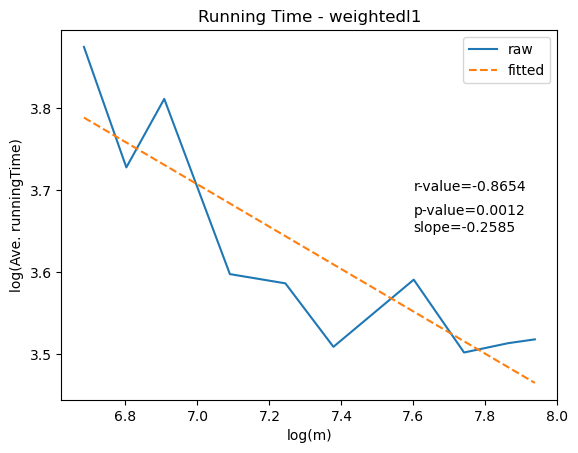

In [237]:
runningTimes_m_weightedl1 = pickleLoad('runningTimes_m_weightedl1')

plt.plot(np.log(mPool),np.log(runningTimes_m_weightedl1),label='raw')
plt.xlabel('log(m)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - weightedl1')

result = stats.linregress(np.log(mPool),np.log(runningTimes_m_weightedl1))
plt.plot(np.log(mPool), result.intercept + result.slope * np.log(mPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(7.6,3.7))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(7.6,3.67))
plt.annotate('slope='+"{:.4f}".format(result.slope),(7.6,3.65))
plt.show()

##### 4.1.2.2.8 reweightedl1


In [230]:
runningTimes = []
for j in range(len(mPool)):
    Phi = sampMats_m[j]
    y = Phi @ x_m
    start = time.time()
    reweightedl1(y, Phi, T0=supp_m[:int(len(supp_m)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_m_reweightedl1')

     pcost       dcost       gap    pres   dres   k/t
 0: -2.5011e-11 -6.0000e+02  7e+06  6e+00  1e-03  1e+00
 1: -1.8395e+04 -1.8649e+04  4e+06  3e+00  5e-04  4e+01
 2: -5.0929e+04 -5.1135e+04  4e+06  3e+00  5e-04  8e+01
 3: -9.9279e+04 -9.9348e+04  3e+06  2e+00  3e-04  1e+02
 4: -6.1443e+04 -6.1457e+04  6e+05  4e-01  7e-05  3e+01
 5: -5.2878e+04 -5.2885e+04  4e+05  3e-01  6e-05  3e+01
 6: -7.5623e+03 -7.5617e+03  8e+04  6e-02  1e-05  7e+00
 7:  8.5751e+03  8.5753e+03  3e+04  3e-02  5e-06  3e+00
 8:  1.3296e+04  1.3296e+04  2e+04  2e-02  3e-06  2e+00
 9:  1.6661e+04  1.6661e+04  9e+03  8e-03  1e-06  8e-01
10:  1.8830e+04  1.8830e+04  4e+03  3e-03  5e-07  3e-01
11:  1.9255e+04  1.9255e+04  3e+03  2e-03  4e-07  2e-01
12:  1.9756e+04  1.9756e+04  1e+03  1e-03  2e-07  1e-01
13:  1.9942e+04  1.9942e+04  9e+02  7e-04  1e-07  8e-02
14:  2.0284e+04  2.0284e+04  2e+02  1e-04  3e-08  2e-02
15:  2.0346e+04  2.0346e+04  6e+01  4e-05  8e-09  5e-03
16:  2.0367e+04  2.0367e+04  1e+01  9e-06  2e-09  

PickleLoad Succeeded. Make sure it's assigned to a variable.


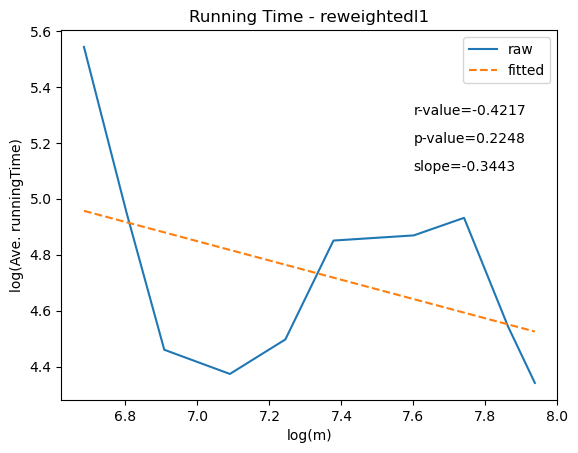

In [240]:
runningTimes_m_reweightedl1 = pickleLoad('runningTimes_m_reweightedl1')

plt.plot(np.log(mPool),np.log(runningTimes_m_reweightedl1),label='raw')
plt.xlabel('log(m)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - reweightedl1')

result = stats.linregress(np.log(mPool),np.log(runningTimes_m_reweightedl1))
plt.plot(np.log(mPool), result.intercept + result.slope * np.log(mPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(7.6,5.3))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(7.6,5.2))
plt.annotate('slope='+"{:.4f}".format(result.slope),(7.6,5.1))
plt.show()

##### 4.1.2.2.9 regModBPDN

In [232]:
runningTimes = []
for j in range(len(mPool)):
    Phi = sampMats_m[j]
    y = Phi @ x_m
    start = time.time()
    regModBPDN(y, Phi, T0=supp_m[:int(len(supp_m)*pR)],x0=x_m)
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_m_regModBPDN')

     pcost       dcost       gap    pres   dres
 0: -5.9776e+03  8.0535e+03  2e+04  2e+02  1e+00
 1:  2.1992e+03 -9.9989e+01  3e+03  3e+00  3e-02
 2:  2.0014e+02 -3.3564e+01  3e+02  3e-01  3e-03
 3: -1.2675e+01 -2.9722e+01  2e+01  2e-02  2e-04
 4: -2.8614e+01 -2.9505e+01  9e-01  5e-04  4e-06
 5: -2.9482e+01 -2.9496e+01  2e-02  7e-06  6e-08
 6: -2.9495e+01 -2.9495e+01  3e-04  1e-07  8e-10
 7: -2.9495e+01 -2.9495e+01  1e-05  1e-09  1e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.9772e+03  8.0576e+03  2e+04  2e+02  1e+00
 1:  2.2223e+03 -9.9374e+01  3e+03  3e+00  3e-02
 2:  1.8873e+02 -3.2911e+01  2e+02  3e-01  2e-03
 3: -1.9825e+01 -2.9280e+01  1e+01  9e-03  7e-05
 4: -2.8937e+01 -2.9116e+01  2e-01  1e-04  1e-06
 5: -2.9106e+01 -2.9109e+01  3e-03  2e-06  1e-08
 6: -2.9109e+01 -2.9109e+01  4e-05  2e-08  1e-10
 7: -2.9109e+01 -2.9109e+01  4e-07  2e-10  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.9783e+03  8.0789e

PickleLoad Succeeded. Make sure it's assigned to a variable.


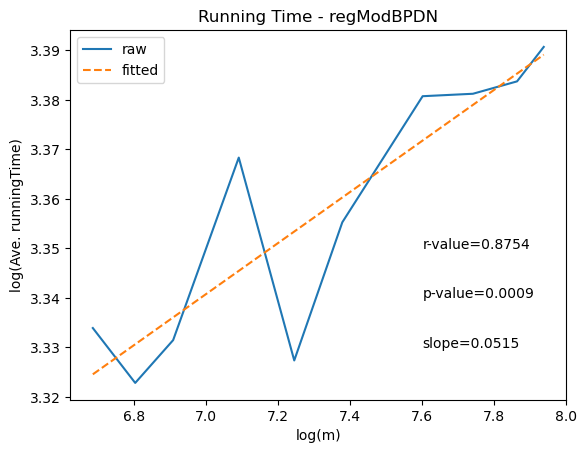

In [238]:
runningTimes_m_regModBPDN = pickleLoad('runningTimes_m_regModBPDN')

plt.plot(np.log(mPool),np.log(runningTimes_m_regModBPDN),label='raw')
plt.xlabel('log(m)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - regModBPDN')

result = stats.linregress(np.log(mPool),np.log(runningTimes_m_regModBPDN))
plt.plot(np.log(mPool), result.intercept + result.slope * np.log(mPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(7.6,3.35))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(7.6,3.34))
plt.annotate('slope='+"{:.4f}".format(result.slope),(7.6,3.33))
plt.show()

#### 4.1.2.3 RunningTime ~ s

In [36]:
n = 1000
m = 600
pR = 0.6
# sPool = np.array([30,35,40,45,50,55,60,70])

# Phi_s = randSampMat(m,n)
# X_s = []
# Supps_s = []
# for j in range(len(sPool)):
#     xx = randSparseSignal(n,sPool[j],1,True)    
#     X_s.append(xx["Signals"][:,0])
#     Supps_s.append(xx["Supports"][:,0])
#     del xx

# pickleSave(sPool,'sPool')
# pickleSave(Phi_s,'Phi_s')
# pickleSave(X_s,'X_s')
# pickleSave(Supps_s,'Supps_s')

PickleSave Succeeded.
PickleSave Succeeded.
PickleSave Succeeded.
PickleSave Succeeded.


In [37]:
sPool = pickleLoad('sPool')
Phi_s = pickleLoad('Phi_s')
X_s = pickleLoad('X_s')
Supps_s = pickleLoad('Supps_s')

PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.


##### 4.1.2.3.1 IHTPKS

In [84]:
runningTimes = []
for j in range(len(sPool)):
    x = X_s[j]
    s = sPool[j]
    supp = Supps_s[j]
    y = Phi_s @ x
    start = time.time()
    IHTPKS(y, Phi_s, s, T0=supp[:int(len(supp)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_s_IHTPKS')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


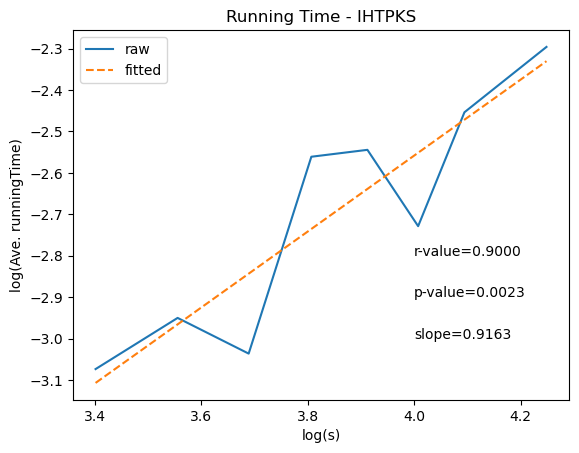

In [40]:
runningTimes_s_IHTPKS = pickleLoad('runningTimes_s_IHTPKS')
plt.plot(np.log(sPool),np.log(runningTimes_s_IHTPKS),label='raw')
plt.xlabel('log(s)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - IHTPKS')

nPool = np.array(sPool)
result = stats.linregress(np.log(sPool),np.log(runningTimes_s_IHTPKS))
plt.plot(np.log(sPool), result.intercept + result.slope * np.log(sPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(4,-2.8))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(4,-2.9))
plt.annotate('slope='+"{:.4f}".format(result.slope),(4,-3))
plt.show()

##### 4.1.2.3.2 OMPPKS

In [42]:
runningTimes = []
for j in range(len(sPool)):
    x = X_s[j]
    s = sPool[j]
    supp = Supps_s[j]
    y = Phi_s @ x
    start = time.time()
    OMPPKS(y, Phi_s, T0=supp[:int(len(supp)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_s_OMPPKS')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


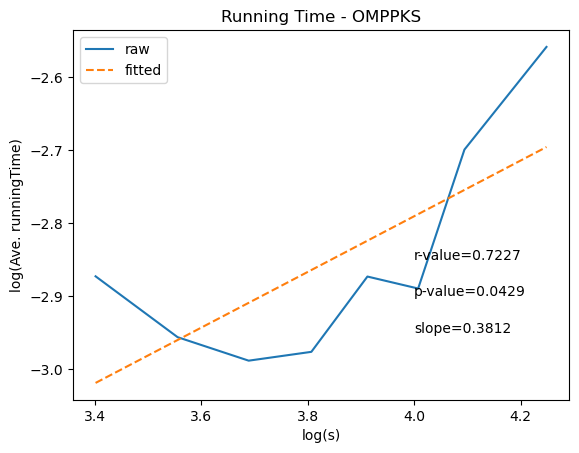

In [50]:
runningTimes_s_OMPPKS = pickleLoad('runningTimes_s_OMPPKS')
plt.plot(np.log(sPool),np.log(runningTimes_s_OMPPKS),label='raw')
plt.xlabel('log(s)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - OMPPKS')

nPool = np.array(sPool)
result = stats.linregress(np.log(sPool),np.log(runningTimes_s_OMPPKS))
plt.plot(np.log(sPool), result.intercept + result.slope * np.log(sPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(4,-2.85))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(4,-2.9))
plt.annotate('slope='+"{:.4f}".format(result.slope),(4,-2.95))
plt.show()

##### 4.1.2.3.3 CosampPKS

In [46]:
runningTimes = []
for j in range(len(sPool)):
    x = X_s[j]
    s = sPool[j]
    supp = Supps_s[j]
    y = Phi_s @ x
    start = time.time()
    CosampPKS(y, Phi_s, s, T0=supp[:int(len(supp)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_s_CosampPKS')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


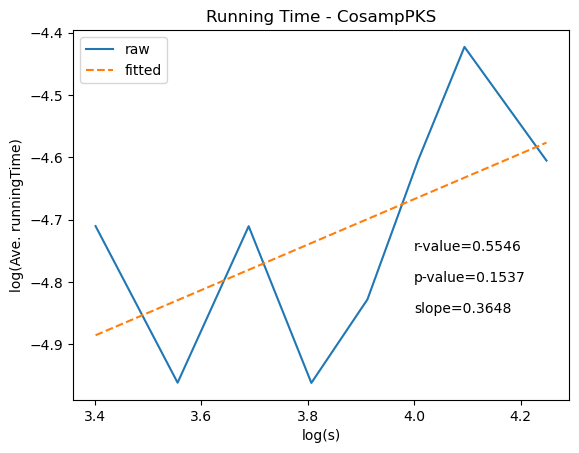

In [48]:
runningTimes_s_CosampPKS = pickleLoad('runningTimes_s_CosampPKS')
plt.plot(np.log(sPool),np.log(runningTimes_s_CosampPKS),label='raw')
plt.xlabel('log(s)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - CosampPKS')

nPool = np.array(sPool)
result = stats.linregress(np.log(sPool),np.log(runningTimes_s_CosampPKS))
plt.plot(np.log(sPool), result.intercept + result.slope * np.log(sPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(4,-4.75))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(4,-4.8))
plt.annotate('slope='+"{:.4f}".format(result.slope),(4,-4.85))
plt.show()

##### 4.1.2.3.4 RWLSSl0PKS

In [53]:
runningTimes = []
for j in range(len(sPool)):
    x = X_s[j]
    s = sPool[j]
    supp = Supps_s[j]
    y = Phi_s @ x
    start = time.time()
    RWLSSl0PKS(y, Phi_s, T0=supp[:int(len(supp)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_s_RWLSSl0PKS')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


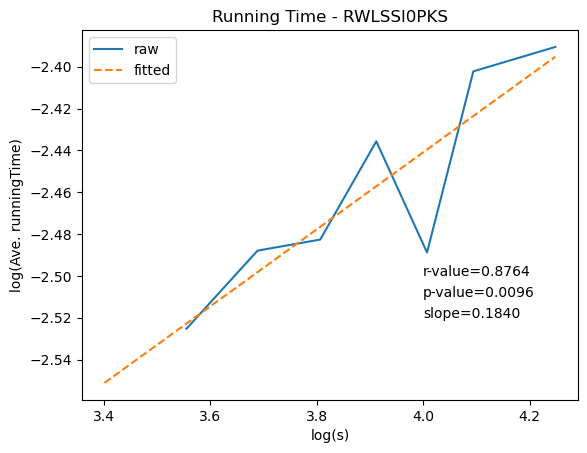

In [56]:
runningTimes = pickleLoad('runningTimes_s_RWLSSl0PKS')
plt.plot(np.log(sPool[1:]),np.log(runningTimes[1:]),label='raw')
plt.xlabel('log(s)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - RWLSSl0PKS')

nPool = np.array(sPool[1:])
result = stats.linregress(np.log(sPool[1:]),np.log(runningTimes[1:]))
plt.plot(np.log(sPool), result.intercept + result.slope * np.log(sPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(4,-2.50))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(4,-2.51))
plt.annotate('slope='+"{:.4f}".format(result.slope),(4,-2.52))
plt.show()

##### 4.1.2.3.5 IRLSPKS

In [66]:
runningTimes = []
for j in range(len(sPool)):
    x = X_s[j]
    s = sPool[j]
    supp = Supps_s[j]
    y = Phi_s @ x
    start = time.time()
    IRLSPKS(y, Phi_s, T0=supp[:int(len(supp)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_s_IRLSPKS')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


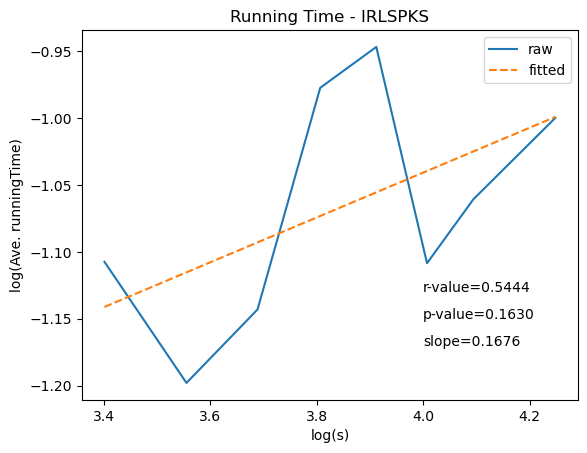

In [63]:
runningTimes = pickleLoad('runningTimes_s_IRLSPKS')
plt.plot(np.log(sPool),np.log(runningTimes),label='raw')
plt.xlabel('log(s)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - IRLSPKS')

nPool = np.array(sPool)
result = stats.linregress(np.log(sPool),np.log(runningTimes))
plt.plot(np.log(sPool), result.intercept + result.slope * np.log(sPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(4,-1.13))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(4,-1.15))
plt.annotate('slope='+"{:.4f}".format(result.slope),(4,-1.17))
plt.show()

##### 4.1.2.3.6 ModCS

In [67]:
runningTimes = []
for j in range(len(sPool)):
    x = X_s[j]
    s = sPool[j]
    supp = Supps_s[j]
    y = Phi_s @ x
    start = time.time()
    ModCS(y, Phi_s, T0=supp[:int(len(supp)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_s_ModCS')

     pcost       dcost       gap    pres   dres   k/t
 0:  3.9413e-15 -2.0000e+02  8e+03  6e+00  1e+00  1e+00
 1: -4.9717e+01 -8.2340e+01  7e+02  1e+00  2e-01  8e-01
 2: -2.4890e+01 -3.9842e+01  3e+02  5e-01  8e-02  4e-01
 3:  2.4535e+00  1.0498e+00  2e+01  4e-02  7e-03  1e-02
 4:  7.2557e+00  6.6874e+00  8e+00  2e-02  3e-03  5e-03
 5:  9.0071e+00  8.7438e+00  4e+00  8e-03  1e-03  2e-03
 6:  9.9003e+00  9.7924e+00  1e+00  3e-03  5e-04  8e-04
 7:  1.0242e+01  1.0194e+01  7e-01  2e-03  2e-04  3e-04
 8:  1.0427e+01  1.0410e+01  2e-01  5e-04  8e-05  1e-04
 9:  1.0519e+01  1.0519e+01  4e-03  9e-06  2e-06  1e-06
10:  1.0521e+01  1.0521e+01  4e-05  9e-08  2e-08  1e-08
11:  1.0521e+01  1.0521e+01  4e-07  9e-10  2e-10  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  7.8826e-15 -2.0000e+02  8e+03  5e+00  1e+00  1e+00
 1: -4.7206e+01 -8.0846e+01  7e+02  9e-01  2e-01  8e-01
 2: -2.4281e+01 -4.0448e+01  3e+02  5e-01  8e-02  4e-01
 3:  2.8455e+00  1.0120e+00 

PickleLoad Succeeded. Make sure it's assigned to a variable.


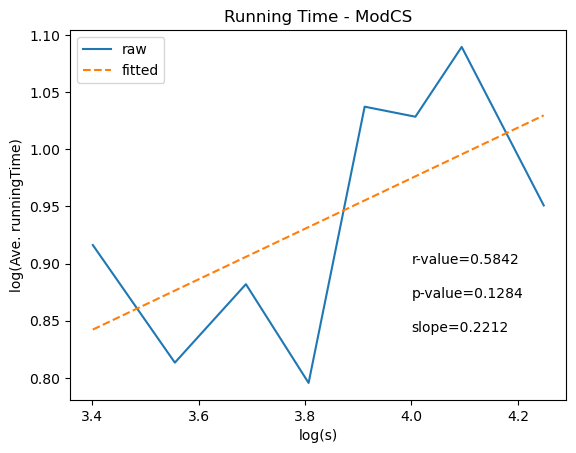

In [69]:
runningTimes = pickleLoad('runningTimes_s_ModCS')
plt.plot(np.log(sPool),np.log(runningTimes),label='raw')
plt.xlabel('log(s)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - ModCS')

nPool = np.array(sPool)
result = stats.linregress(np.log(sPool),np.log(runningTimes))
plt.plot(np.log(sPool), result.intercept + result.slope * np.log(sPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(4,0.9))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(4,0.87))
plt.annotate('slope='+"{:.4f}".format(result.slope),(4,0.84))
plt.show()

##### 4.1.2.3.7 weightedl1

In [70]:
runningTimes = []
for j in range(len(sPool)):
    x = X_s[j]
    s = sPool[j]
    supp = Supps_s[j]
    y = Phi_s @ x
    start = time.time()
    weightedl1(y, Phi_s, T0=supp[:int(len(supp)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_s_weightedl1')

     pcost       dcost       gap    pres   dres   k/t
 0:  4.4409e-15 -2.0000e+02  8e+03  6e+00  1e+00  1e+00
 1: -4.9659e+01 -8.1961e+01  7e+02  1e+00  2e-01  8e-01
 2: -2.4766e+01 -3.9682e+01  3e+02  5e-01  8e-02  4e-01
 3:  2.7101e+00  1.3222e+00  2e+01  4e-02  7e-03  1e-02
 4:  7.4704e+00  6.9084e+00  8e+00  2e-02  3e-03  5e-03
 5:  9.2062e+00  8.9457e+00  4e+00  8e-03  1e-03  2e-03
 6:  1.0044e+01  9.9286e+00  2e+00  4e-03  6e-04  9e-04
 7:  1.0473e+01  1.0432e+01  6e-01  1e-03  2e-04  3e-04
 8:  1.0610e+01  1.0592e+01  2e-01  5e-04  9e-05  1e-04
 9:  1.0671e+01  1.0664e+01  9e-02  2e-04  3e-05  4e-05
10:  1.0707e+01  1.0707e+01  1e-03  3e-06  5e-07  5e-07
11:  1.0708e+01  1.0708e+01  1e-05  3e-08  5e-09  5e-09
12:  1.0708e+01  1.0708e+01  1e-07  3e-10  5e-11  5e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  7.4385e-15 -2.0000e+02  8e+03  5e+00  1e+00  1e+00
 1: -4.7159e+01 -8.0362e+01  7e+02  9e-01  2e-01  8e-01
 2: -2.4176e+01 -4.0296e+01 

PickleLoad Succeeded. Make sure it's assigned to a variable.


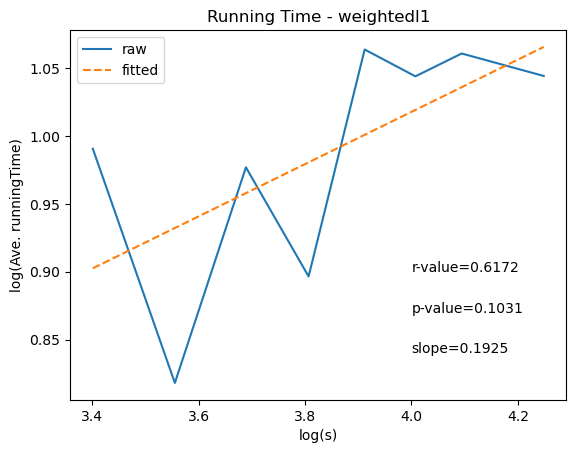

In [72]:
runningTimes = pickleLoad('runningTimes_s_weightedl1')
plt.plot(np.log(sPool),np.log(runningTimes),label='raw')
plt.xlabel('log(s)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - weightedl1')

nPool = np.array(sPool)
result = stats.linregress(np.log(sPool),np.log(runningTimes))
plt.plot(np.log(sPool), result.intercept + result.slope * np.log(sPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(4,0.9))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(4,0.87))
plt.annotate('slope='+"{:.4f}".format(result.slope),(4,0.84))
plt.show()

##### 4.1.2.3.8 reweightedl1

In [73]:
runningTimes = []
for j in range(len(sPool)):
    x = X_s[j]
    s = sPool[j]
    supp = Supps_s[j]
    y = Phi_s @ x
    start = time.time()
    reweightedl1(y, Phi_s, T0=supp[:int(len(supp)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_s_reweightedl1')

     pcost       dcost       gap    pres   dres   k/t
 0:  3.8085e-12 -2.0000e+02  3e+06  6e+00  1e-03  1e+00
 1: -5.5204e+03 -5.5738e+03  1e+06  3e+00  5e-04  4e+01
 2: -1.3952e+04 -1.3964e+04  1e+06  3e+00  5e-04  8e+01
 3: -3.2281e+04 -3.2220e+04  1e+06  2e+00  4e-04  1e+02
 4: -1.8527e+04 -1.8509e+04  3e+05  6e-01  1e-04  4e+01
 5: -5.7237e+03 -5.7131e+03  8e+04  2e-01  3e-05  2e+01
 6:  9.0999e+03  9.1014e+03  1e+04  3e-02  5e-06  2e+00
 7:  1.0878e+04  1.0878e+04  5e+03  1e-02  2e-06  1e+00
 8:  1.1671e+04  1.1671e+04  2e+03  5e-03  8e-07  4e-01
 9:  1.2191e+04  1.2191e+04  3e+02  6e-04  1e-07  6e-02
10:  1.2237e+04  1.2237e+04  1e+02  3e-04  5e-08  3e-02
11:  1.2282e+04  1.2282e+04  7e+00  2e-05  3e-09  2e-03
12:  1.2285e+04  1.2285e+04  7e-02  2e-07  3e-11  2e-05
13:  1.2285e+04  1.2285e+04  7e-04  2e-09  3e-13  2e-07
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0232e-12 -2.0000e+02  2e+06  6e+00  1e-03  1e+00
 1: -2.9014e+02 -2.9440e+02 

PickleLoad Succeeded. Make sure it's assigned to a variable.


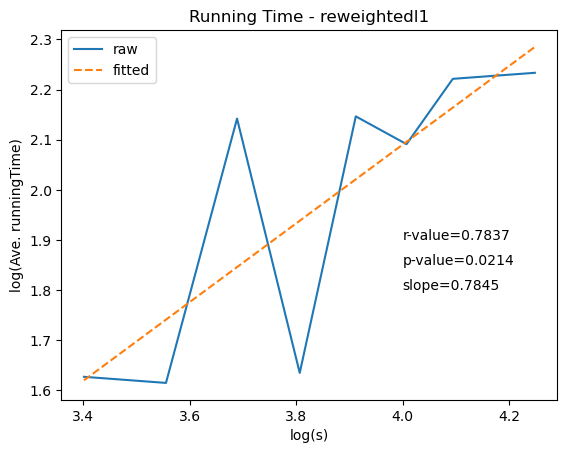

In [79]:
runningTimes = pickleLoad('runningTimes_s_reweightedl1')
plt.plot(np.log(sPool),np.log(runningTimes),label='raw')
plt.xlabel('log(s)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - reweightedl1')

nPool = np.array(sPool)
result = stats.linregress(np.log(sPool),np.log(runningTimes))
plt.plot(np.log(sPool), result.intercept + result.slope * np.log(sPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(4,1.9))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(4,1.85))
plt.annotate('slope='+"{:.4f}".format(result.slope),(4,1.8))
plt.show()

##### 4.1.2.3.9 regModBPDN

In [76]:
runningTimes = []
for j in range(len(sPool)):
    x = X_s[j]
    s = sPool[j]
    supp = Supps_s[j]
    y = Phi_s @ x
    start = time.time()
    regModBPDN(y, Phi_s, T0=supp[:int(len(supp)*pR)], x0=x)
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_s_regModBPDN')

     pcost       dcost       gap    pres   dres
 0: -1.9866e+03  2.6938e+03  6e+03  1e+02  1e+00
 1:  7.8938e+02 -4.1819e+01  9e+02  2e+00  2e-02
 2:  4.8286e+01 -1.9477e+01  7e+01  1e-01  2e-03
 3: -1.6023e+01 -1.8228e+01  2e+00  3e-03  4e-05
 4: -1.8118e+01 -1.8168e+01  5e-02  5e-05  6e-07
 5: -1.8162e+01 -1.8163e+01  2e-03  7e-07  9e-09
 6: -1.8163e+01 -1.8163e+01  6e-05  8e-09  1e-10
 7: -1.8163e+01 -1.8163e+01  8e-07  8e-11  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9853e+03  2.6838e+03  6e+03  1e+02  1e+00
 1:  7.9836e+02 -4.6915e+01  9e+02  2e+00  2e-02
 2:  5.0099e+01 -2.3151e+01  8e+01  1e-01  2e-03
 3: -1.9026e+01 -2.1478e+01  3e+00  3e-03  4e-05
 4: -2.1312e+01 -2.1376e+01  7e-02  7e-05  9e-07
 5: -2.1365e+01 -2.1367e+01  2e-03  9e-07  1e-08
 6: -2.1366e+01 -2.1366e+01  7e-05  1e-08  1e-10
 7: -2.1366e+01 -2.1366e+01  2e-06  1e-10  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9826e+03  2.6864e

PickleLoad Succeeded. Make sure it's assigned to a variable.


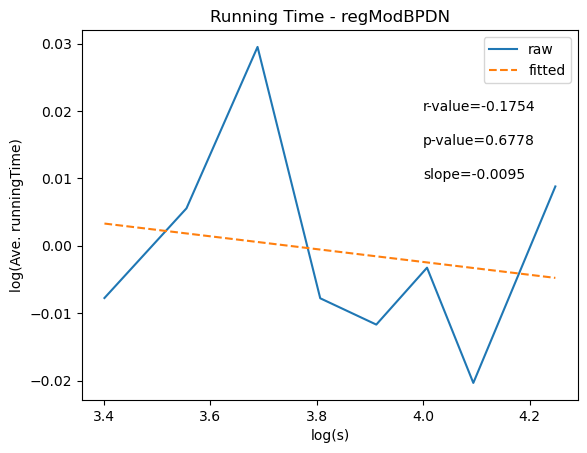

In [78]:
runningTimes = pickleLoad('runningTimes_s_regModBPDN')
plt.plot(np.log(sPool),np.log(runningTimes),label='raw')
plt.xlabel('log(s)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - regModBPDN')

nPool = np.array(sPool)
result = stats.linregress(np.log(sPool),np.log(runningTimes))
plt.plot(np.log(sPool), result.intercept + result.slope * np.log(sPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(4,0.02))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(4,0.015))
plt.annotate('slope='+"{:.4f}".format(result.slope),(4,0.01))
plt.show()

#### 4.1.2.4 RunningTime ~ pR

In [88]:
n = 1000
m = 600
s = 50
# pRPool = np.array([0.2,0.4,0.6,0.8,1.]) # total 5.

# Phi_p = randSampMat(m,n)
# xx = randSparseSignal(n,s,1,True)    
# x_p = xx["Signals"][:,0]
# supp_p = xx["Supports"][:,0]
# del xx

# pickleSave(pRPool,'pRPool')
# pickleSave(Phi_p,'Phi_p')
# pickleSave(x_p,'x_p')
# pickleSave(supp_p,'supp_p')

PickleSave Succeeded.
PickleSave Succeeded.
PickleSave Succeeded.
PickleSave Succeeded.


In [89]:
pRPool = pickleLoad('pRPool')
Phi_p = pickleLoad('Phi_p')
x_p = pickleLoad('x_p')
supp_p = pickleLoad('supp_p')

PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.


##### 4.1.2.4.1 IHTPKS

In [90]:
runningTimes = []
for j in range(len(pRPool)):
    pR = pRPool[j]
    y = Phi_p @ x_p
    start = time.time()
    IHTPKS(y, Phi_s, s, T0=supp_p[:int(len(supp_p)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_p_IHTPKS')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


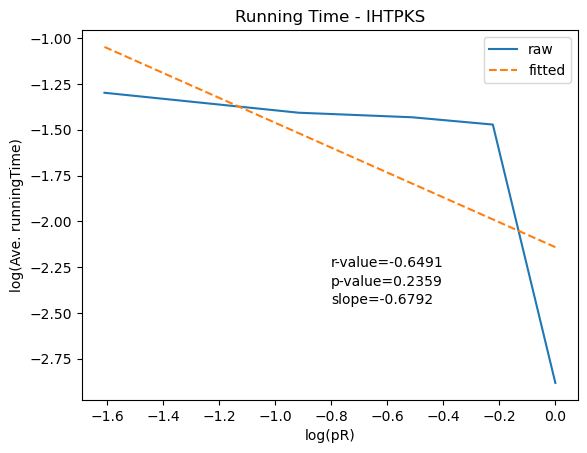

In [92]:
runningTimes = pickleLoad('runningTimes_p_IHTPKS')
plt.plot(np.log(pRPool),np.log(runningTimes),label='raw')
plt.xlabel('log(pR)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - IHTPKS')

nPool = np.array(pRPool)
result = stats.linregress(np.log(pRPool),np.log(runningTimes))
plt.plot(np.log(pRPool), result.intercept + result.slope * np.log(pRPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(-0.8, -2.25))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(-0.8, -2.35))
plt.annotate('slope='+"{:.4f}".format(result.slope),(-0.8, -2.45))
plt.show()

##### 4.1.2.4.2 OMPPKS

In [93]:
runningTimes = []
for j in range(len(pRPool)):
    pR = pRPool[j]
    y = Phi_p @ x_p
    start = time.time()
    OMPPKS(y, Phi_s, T0=supp_p[:int(len(supp_p)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_p_OMPPKS')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


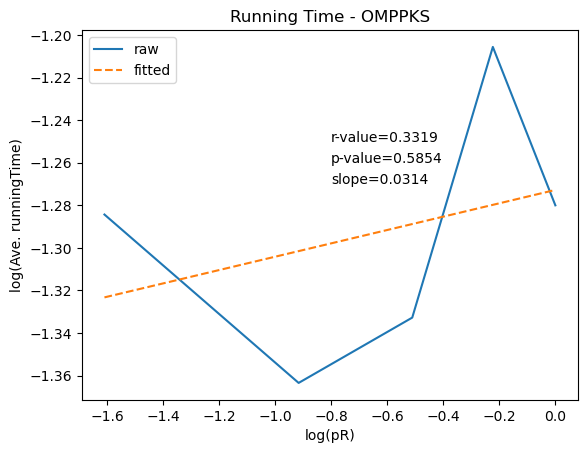

In [95]:
runningTimes = pickleLoad('runningTimes_p_OMPPKS')
plt.plot(np.log(pRPool),np.log(runningTimes),label='raw')
plt.xlabel('log(pR)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - OMPPKS')

nPool = np.array(pRPool)
result = stats.linregress(np.log(pRPool),np.log(runningTimes))
plt.plot(np.log(pRPool), result.intercept + result.slope * np.log(pRPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(-0.8, -1.25))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(-0.8, -1.26))
plt.annotate('slope='+"{:.4f}".format(result.slope),(-0.8, -1.27))
plt.show()

##### 4.1.2.4.3 CosampPKS

In [96]:
runningTimes = []
for j in range(len(pRPool)):
    pR = pRPool[j]
    y = Phi_p @ x_p
    start = time.time()
    CosampPKS(y, Phi_s, s, T0=supp_p[:int(len(supp_p)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_p_CosampPKS')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


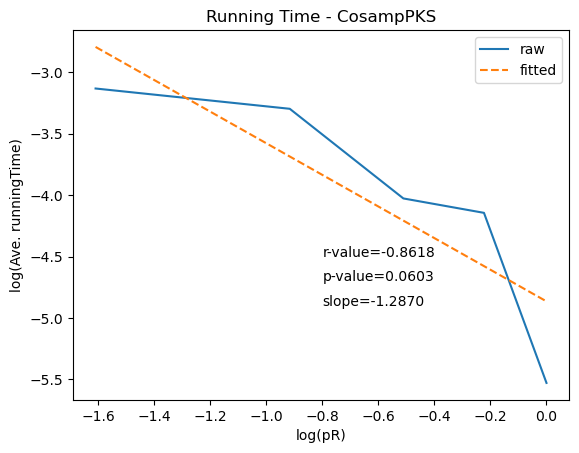

In [98]:
runningTimes = pickleLoad('runningTimes_p_CosampPKS')
plt.plot(np.log(pRPool),np.log(runningTimes),label='raw')
plt.xlabel('log(pR)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - CosampPKS')

nPool = np.array(pRPool)
result = stats.linregress(np.log(pRPool),np.log(runningTimes))
plt.plot(np.log(pRPool), result.intercept + result.slope * np.log(pRPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(-0.8, -4.5))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(-0.8, -4.7))
plt.annotate('slope='+"{:.4f}".format(result.slope),(-0.8, -4.9))
plt.show()

##### 4.1.2.4.4 RWLSSl0PKS

In [99]:
runningTimes = []
for j in range(len(pRPool)):
    pR = pRPool[j]
    y = Phi_p @ x_p
    start = time.time()
    RWLSSl0PKS(y, Phi_s, T0=supp_p[:int(len(supp_p)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_p_RWLSSl0PKS')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


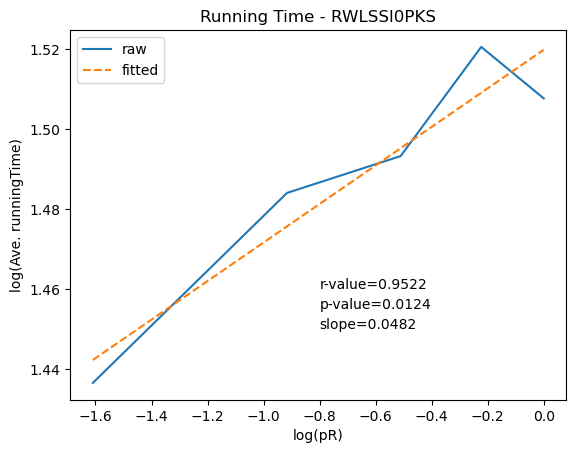

In [101]:
runningTimes = pickleLoad('runningTimes_p_RWLSSl0PKS')
plt.plot(np.log(pRPool),np.log(runningTimes),label='raw')
plt.xlabel('log(pR)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - RWLSSl0PKS')

nPool = np.array(pRPool)
result = stats.linregress(np.log(pRPool),np.log(runningTimes))
plt.plot(np.log(pRPool), result.intercept + result.slope * np.log(pRPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(-0.8, 1.46))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(-0.8, 1.455))
plt.annotate('slope='+"{:.4f}".format(result.slope),(-0.8, 1.45))
plt.show()

##### 4.1.2.4.5 IRLSPKS

In [102]:
runningTimes = []
for j in range(len(pRPool)):
    pR = pRPool[j]
    y = Phi_p @ x_p
    start = time.time()
    IRLSPKS(y, Phi_s, T0=supp_p[:int(len(supp_p)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_p_IRLSPKS')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


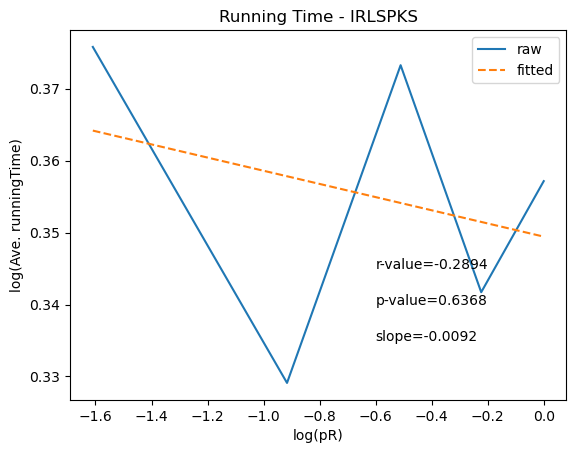

In [104]:
runningTimes = pickleLoad('runningTimes_p_IRLSPKS')
plt.plot(np.log(pRPool),np.log(runningTimes),label='raw')
plt.xlabel('log(pR)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - IRLSPKS')

nPool = np.array(pRPool)
result = stats.linregress(np.log(pRPool),np.log(runningTimes))
plt.plot(np.log(pRPool), result.intercept + result.slope * np.log(pRPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(-0.6, 0.345))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(-0.6, 0.34))
plt.annotate('slope='+"{:.4f}".format(result.slope),(-0.6, 0.335))
plt.show()

##### 4.1.2.4.6 ModCS

In [105]:
runningTimes = []
for j in range(len(pRPool)):
    pR = pRPool[j]
    y = Phi_p @ x_p
    start = time.time()
    ModCS(y, Phi_s, T0=supp_p[:int(len(supp_p)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_p_ModCS')

     pcost       dcost       gap    pres   dres   k/t
 0: -1.5099e-14 -2.0000e+02  8e+03  6e+00  1e+00  1e+00
 1: -2.6919e+01 -5.2205e+01  5e+02  7e-01  1e-01  8e-01
 2:  1.4521e+01 -2.2045e+00  3e+02  5e-01  9e-02  5e-01
 3:  4.7189e+01  3.9786e+01  1e+02  2e-01  4e-02  2e-01
 4:  6.4980e+01  6.1994e+01  5e+01  9e-02  2e-02  7e-02
 5:  7.2714e+01  7.1474e+01  2e+01  4e-02  6e-03  2e-02
 6:  7.6167e+01  7.5661e+01  9e+00  1e-02  3e-03  8e-03
 7:  7.7613e+01  7.7383e+01  4e+00  7e-03  1e-03  3e-03
 8:  7.8332e+01  7.8229e+01  2e+00  3e-03  5e-04  1e-03
 9:  7.8703e+01  7.8666e+01  6e-01  1e-03  2e-04  4e-04
10:  7.8839e+01  7.8823e+01  3e-01  4e-04  8e-05  1e-04
11:  7.8900e+01  7.8894e+01  9e-02  2e-04  3e-05  4e-05
12:  7.8920e+01  7.8918e+01  4e-02  7e-05  1e-05  2e-05
13:  7.8933e+01  7.8932e+01  7e-03  1e-05  2e-06  3e-06
14:  7.8935e+01  7.8935e+01  1e-03  2e-06  3e-07  3e-07
15:  7.8936e+01  7.8936e+01  2e-04  3e-07  6e-08  6e-08
16:  7.8936e+01  7.8936e+01  8e-05  1e-07  2e-08  

PickleLoad Succeeded. Make sure it's assigned to a variable.


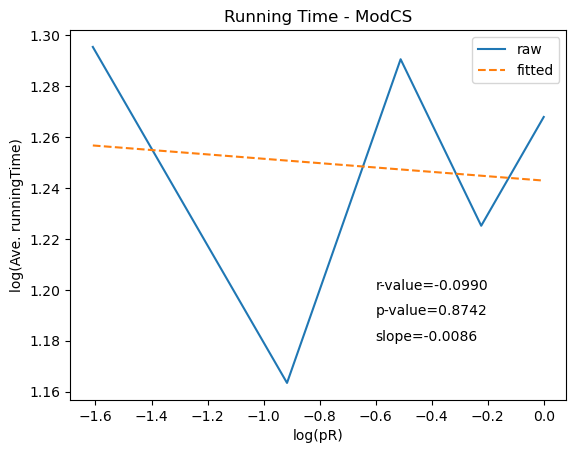

In [113]:
runningTimes = pickleLoad('runningTimes_p_ModCS')
plt.plot(np.log(pRPool),np.log(runningTimes),label='raw')
plt.xlabel('log(pR)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - ModCS')

nPool = np.array(pRPool)
result = stats.linregress(np.log(pRPool),np.log(runningTimes))
plt.plot(np.log(pRPool), result.intercept + result.slope * np.log(pRPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(-0.6, 1.2))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(-0.6, 1.19))
plt.annotate('slope='+"{:.4f}".format(result.slope),(-0.6, 1.18))
plt.show()

##### 4.1.2.4.7 weightedl1

In [107]:
runningTimes = []
for j in range(len(pRPool)):
    pR = pRPool[j]
    y = Phi_p @ x_p
    start = time.time()
    weightedl1(y, Phi_s, T0=supp_p[:int(len(supp_p)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_p_weightedl1')

     pcost       dcost       gap    pres   dres   k/t
 0: -1.4877e-14 -2.0000e+02  8e+03  6e+00  1e+00  1e+00
 1: -2.6894e+01 -5.2186e+01  5e+02  7e-01  1e-01  8e-01
 2:  1.4557e+01 -2.1734e+00  3e+02  5e-01  9e-02  5e-01
 3:  4.7216e+01  3.9806e+01  1e+02  2e-01  4e-02  2e-01
 4:  6.4998e+01  6.2004e+01  5e+01  9e-02  2e-02  7e-02
 5:  7.2730e+01  7.1486e+01  2e+01  4e-02  6e-03  2e-02
 6:  7.6182e+01  7.5673e+01  9e+00  1e-02  3e-03  8e-03
 7:  7.7641e+01  7.7411e+01  4e+00  7e-03  1e-03  3e-03
 8:  7.8365e+01  7.8263e+01  2e+00  3e-03  5e-04  1e-03
 9:  7.8737e+01  7.8701e+01  6e-01  1e-03  2e-04  3e-04
10:  7.8854e+01  7.8837e+01  3e-01  5e-04  9e-05  1e-04
11:  7.8913e+01  7.8905e+01  1e-01  2e-04  4e-05  6e-05
12:  7.8947e+01  7.8944e+01  4e-02  7e-05  1e-05  2e-05
13:  7.8958e+01  7.8957e+01  1e-02  2e-05  4e-06  5e-06
14:  7.8962e+01  7.8962e+01  4e-03  7e-06  1e-06  1e-06
15:  7.8963e+01  7.8963e+01  5e-04  8e-07  1e-07  1e-07
16:  7.8964e+01  7.8964e+01  1e-04  2e-07  3e-08  

PickleLoad Succeeded. Make sure it's assigned to a variable.


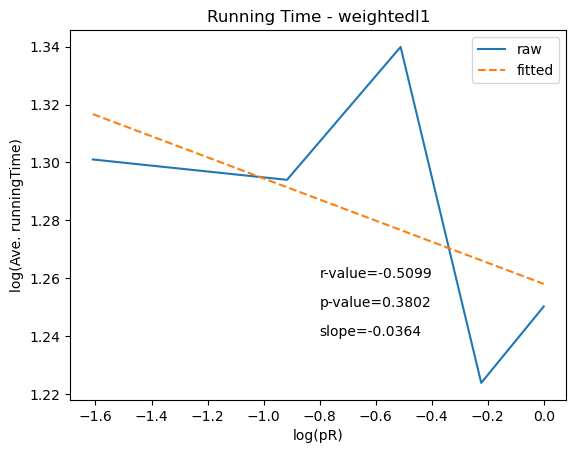

In [114]:
runningTimes = pickleLoad('runningTimes_p_weightedl1')
plt.plot(np.log(pRPool),np.log(runningTimes),label='raw')
plt.xlabel('log(pR)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - weightedl1')

nPool = np.array(pRPool)
result = stats.linregress(np.log(pRPool),np.log(runningTimes))
plt.plot(np.log(pRPool), result.intercept + result.slope * np.log(pRPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(-0.8, 1.26))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(-0.8, 1.25))
plt.annotate('slope='+"{:.4f}".format(result.slope),(-0.8, 1.24))
plt.show()

##### 4.1.2.4.8 reweightedl1

In [109]:
runningTimes = []
for j in range(len(pRPool)):
    pR = pRPool[j]
    y = Phi_p @ x_p
    start = time.time()
    reweightedl1(y, Phi_s, T0=supp_p[:int(len(supp_p)*pR)])
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_p_reweightedl1')

     pcost       dcost       gap    pres   dres   k/t
 0: -1.2733e-11 -2.0000e+02  2e+06  6e+00  1e-03  1e+00
 1: -3.6636e+03 -3.7196e+03  1e+06  2e+00  4e-04  3e+01
 2: -5.4958e+03 -5.5261e+03  1e+06  2e+00  4e-04  5e+01
 3: -1.7953e+04 -1.7923e+04  1e+06  2e+00  4e-04  1e+02
 4:  3.6021e+03  3.6178e+03  3e+05  7e-01  1e-04  4e+01
 5:  2.7053e+04  2.7076e+04  2e+05  4e-01  8e-05  4e+01
 6:  4.5484e+04  4.5499e+04  1e+05  3e-01  4e-05  2e+01
 7:  6.3419e+04  6.3426e+04  5e+04  1e-01  2e-05  1e+01
 8:  7.1404e+04  7.1408e+04  2e+04  4e-02  8e-06  5e+00
 9:  7.5242e+04  7.5244e+04  1e+04  2e-02  3e-06  2e+00
10:  7.7077e+04  7.7078e+04  5e+03  1e-02  2e-06  1e+00
11:  7.8202e+04  7.8203e+04  2e+03  4e-03  8e-07  6e-01
12:  7.8761e+04  7.8761e+04  1e+03  2e-03  3e-07  2e-01
13:  7.9004e+04  7.9004e+04  4e+02  8e-04  1e-07  1e-01
14:  7.9125e+04  7.9125e+04  2e+02  3e-04  5e-08  4e-02
15:  7.9175e+04  7.9175e+04  6e+01  1e-04  2e-08  1e-02
16:  7.9193e+04  7.9193e+04  2e+01  4e-05  7e-09  

PickleLoad Succeeded. Make sure it's assigned to a variable.


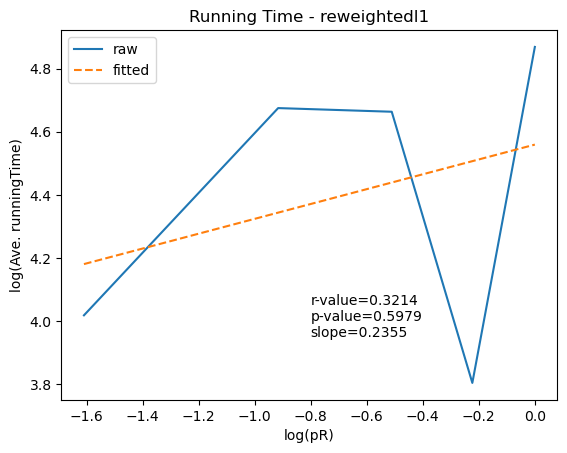

In [115]:
runningTimes = pickleLoad('runningTimes_p_reweightedl1')
plt.plot(np.log(pRPool),np.log(runningTimes),label='raw')
plt.xlabel('log(pR)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - reweightedl1')

nPool = np.array(pRPool)
result = stats.linregress(np.log(pRPool),np.log(runningTimes))
plt.plot(np.log(pRPool), result.intercept + result.slope * np.log(pRPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(-0.8, 4.05))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(-0.8, 4.0))
plt.annotate('slope='+"{:.4f}".format(result.slope),(-0.8, 3.95))
plt.show()

##### 4.1.2.4.9 regModBPDN

In [111]:
runningTimes = []
for j in range(len(pRPool)):
    pR = pRPool[j]
    y = Phi_p @ x_p
    start = time.time()
    regModBPDN(y, Phi_s, T0=supp_p[:int(len(supp_p)*pR)], x0=x)
    end = time.time()
    delta = end - start
    runningTimes.append(delta)

pickleSave(runningTimes,'runningTimes_p_regModBPDN')

     pcost       dcost       gap    pres   dres
 0: -2.0017e+03  2.1423e+03  5e+03  1e+02  1e+00
 1:  6.3622e+02 -2.1792e+01  7e+02  2e+00  2e-02
 2:  5.4807e+01 -2.4735e+00  6e+01  1e-01  1e-03
 3:  2.9296e+00 -2.7763e-01  3e+00  5e-03  5e-05
 4: -1.5976e-01 -2.2282e-01  7e-02  7e-05  7e-07
 5: -2.2136e-01 -2.2228e-01  1e-03  8e-07  9e-09
 6: -2.2226e-01 -2.2227e-01  1e-05  8e-09  9e-11
 7: -2.2227e-01 -2.2227e-01  1e-07  8e-11  9e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9820e+03  2.4908e+03  6e+03  1e+02  1e+00
 1:  7.3539e+02 -2.6752e+01  8e+02  2e+00  2e-02
 2:  6.2184e+01 -3.2724e+00  7e+01  1e-01  2e-03
 3:  3.1889e+00 -7.0791e-01  4e+00  5e-03  6e-05
 4: -5.5866e-01 -6.3595e-01  8e-02  7e-05  9e-07
 5: -6.3434e-01 -6.3535e-01  1e-03  8e-07  1e-08
 6: -6.3533e-01 -6.3534e-01  1e-05  8e-09  1e-10
 7: -6.3534e-01 -6.3534e-01  1e-07  8e-11  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9630e+03  2.4756e

PickleLoad Succeeded. Make sure it's assigned to a variable.


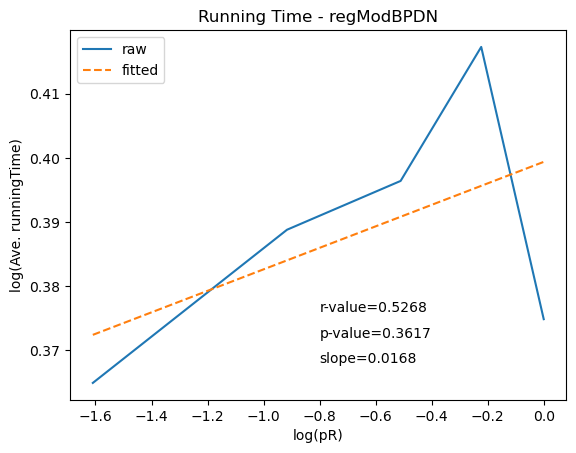

In [116]:
runningTimes = pickleLoad('runningTimes_p_regModBPDN')
plt.plot(np.log(pRPool),np.log(runningTimes),label='raw')
plt.xlabel('log(pR)')
plt.ylabel('log(Ave. runningTime)')
plt.title('Running Time - regModBPDN')

nPool = np.array(pRPool)
result = stats.linregress(np.log(pRPool),np.log(runningTimes))
plt.plot(np.log(pRPool), result.intercept + result.slope * np.log(pRPool), '--', label='fitted')
plt.legend()
plt.annotate('r-value='+"{:.4f}".format(result.rvalue),(-0.8, 0.376))
plt.annotate('p-value='+"{:.4f}".format(result.pvalue),(-0.8, 0.372))
plt.annotate('slope='+"{:.4f}".format(result.slope),(-0.8, 0.368))
plt.show()

### 4.1.3 Error, (generalised/sparsified) precision, recall, F1-score, w.r.t. pR, m/RIC (sorting out)
See "Test.ipynb".

## 4.2 Real MRI data for DCS

### 4.2.1 Error w.r.t. prior info param alpha

# Exec! (Old.数值测试)
Could serve for reference.

In [44]:
# regModBPDN
x = regModBPDN(Y[:, 0], A, gamma=0.01)
# 允许index out of range.
err = np.linalg.norm(x - X[:, 0])
print(err)


     pcost       dcost       gap    pres   dres
 0: -1.3861e+01  1.2351e+01  3e+03  5e+01  3e+00
 1:  8.8466e+00 -3.8210e+01  5e+01  5e-01  3e-02
 2: -7.2986e+00 -1.3785e+01  6e+00  6e-15  5e-15
 3: -1.1824e+01 -1.3683e+01  2e+00  2e-15  2e-15
 4: -1.2613e+01 -1.3638e+01  1e+00  1e-15  1e-15
 5: -1.3314e+01 -1.3640e+01  3e-01  1e-15  7e-16
 6: -1.3591e+01 -1.3624e+01  3e-02  1e-15  7e-16
 7: -1.3619e+01 -1.3622e+01  3e-03  9e-16  7e-16
 8: -1.3622e+01 -1.3622e+01  2e-04  8e-16  7e-16
 9: -1.3622e+01 -1.3622e+01  7e-06  8e-16  7e-16
Optimal solution found.
0.07013603381944279


In [47]:
# wl1
x = weightedl1(Y[:, 0], A, T0=Supps[:, 0][:20], lamb=1e-2)
# 允许index out of range.
err = np.linalg.norm(x - X[:, 0])
print(err)


     pcost       dcost       gap    pres   dres   k/t
 0: -6.8390e-14 -6.0000e+00  7e+03  1e+00  1e+00  1e+00
 1:  1.3699e+02  1.3548e+02  2e+03  5e-01  4e-01  1e+00
 2:  1.1865e+02  1.1807e+02  9e+02  2e-01  2e-01  7e-01
 3:  9.8492e+01  9.8486e+01  5e+01  1e-02  1e-02  7e-02
 4:  1.0005e+02  1.0005e+02  4e+00  2e-03  1e-03  3e-03
 5:  1.0157e+02  1.0157e+02  7e-01  3e-04  3e-04  8e-04
 6:  1.0174e+02  1.0174e+02  2e-01  1e-04  9e-05  3e-04
 7:  1.0180e+02  1.0180e+02  9e-02  4e-05  4e-05  1e-04
 8:  1.0182e+02  1.0182e+02  6e-02  3e-05  2e-05  6e-05
 9:  1.0183e+02  1.0183e+02  2e-02  7e-06  6e-06  1e-05
10:  1.0184e+02  1.0184e+02  7e-03  3e-06  3e-06  6e-06
11:  1.0184e+02  1.0184e+02  1e-03  7e-07  5e-07  1e-06
12:  1.0184e+02  1.0184e+02  7e-05  3e-08  3e-08  6e-08
Optimal solution found.
0.08012917775931015


In [60]:
# rwl1
x = reweightedl1(Y[:, 0], A, lamb=1e-2, showChangeRate=True)
# 允许index out of range.
err = np.linalg.norm(x - X[:, 0])
print(err)


     pcost       dcost       gap    pres   dres   k/t
 0: -8.5038e-11 -6.0000e+00  2e+06  1e+00  1e-03  1e+00
 1:  6.8710e+04  7.0453e+04  3e+06  1e+00  9e-04  2e+03
 2:  2.3171e+05  2.3236e+05  1e+06  3e-01  3e-04  7e+02
 3:  2.6847e+05  2.6891e+05  6e+05  2e-01  2e-04  4e+02
 4:  2.9286e+05  2.9292e+05  7e+04  2e-02  2e-05  6e+01
 5:  2.9710e+05  2.9710e+05  7e+03  3e-03  2e-06  4e+00
 6:  2.9915e+05  2.9915e+05  1e+03  5e-04  4e-07  1e+00
 7:  2.9947e+05  2.9947e+05  3e+02  1e-04  1e-07  3e-01
 8:  2.9956e+05  2.9956e+05  8e+01  4e-05  3e-08  7e-02
 9:  2.9958e+05  2.9958e+05  3e+01  2e-05  1e-08  3e-02
10:  2.9958e+05  2.9958e+05  1e+01  7e-06  6e-09  1e-02
11:  2.9959e+05  2.9959e+05  9e+00  4e-06  3e-09  7e-03
12:  2.9959e+05  2.9959e+05  4e+00  2e-06  2e-09  4e-03
13:  2.9959e+05  2.9959e+05  4e-01  2e-07  1e-10  3e-04
14:  2.9959e+05  2.9959e+05  3e-02  2e-08  1e-11  3e-05
Optimal solution found.
Iter: 0 ChangeRate: 0.9999999999999998
     pcost       dcost       gap    pres   

In [93]:
# ModCS
x = ModCS(Y[:, 0], A, T0=Supps[:, 0][:20], lamb=1e-2)
# 允许index out of range.
err = np.linalg.norm(x - X[:, 0])
print(err)


     pcost       dcost       gap    pres   dres   k/t
 0:  7.6534e-14 -8.0000e+00  9e+03  1e+00  1e+00  1e+00
 1:  1.3650e+02  1.3441e+02  2e+03  4e-01  4e-01  1e+00
 2:  1.2304e+02  1.2186e+02  1e+03  3e-01  2e-01  9e-01
 3:  9.6427e+01  9.6261e+01  3e+02  7e-02  6e-02  4e-01
 4:  9.5616e+01  9.5601e+01  1e+01  3e-03  3e-03  8e-03
 5:  9.9352e+01  9.9349e+01  2e+00  5e-04  5e-04  1e-03
 6:  9.9656e+01  9.9655e+01  6e-01  2e-04  2e-04  5e-04
 7:  9.9764e+01  9.9764e+01  2e-01  8e-05  7e-05  2e-04
 8:  9.9805e+01  9.9805e+01  9e-02  3e-05  3e-05  7e-05
 9:  9.9823e+01  9.9823e+01  4e-02  1e-05  1e-05  3e-05
10:  9.9835e+01  9.9835e+01  9e-03  3e-06  3e-06  6e-06
11:  9.9838e+01  9.9838e+01  2e-03  9e-07  8e-07  2e-06
12:  9.9838e+01  9.9838e+01  2e-04  8e-08  7e-08  1e-07
13:  9.9838e+01  9.9838e+01  1e-05  5e-09  4e-09  8e-09
Optimal solution found.
0.08167599195576739


In [ ]:
# IRLSPKS
x = IRLSPKS(Y[:, 0], A, showIfMaxIter=True, showChangeRate=True)
err = np.linalg.norm(x - X[:, 0])
print(err)


In [ ]:
# RWLSSl0PKS
x = RWLSSl0PKS(Y[:, 0], A, showIfMaxIter=True, showChangeRate=True)
err = np.linalg.norm(x - X[:, 0])
print(err)


In [ ]:
# CosampPKS
ErrCosampPKS = []
for j in range(Y.shape[1]):
    x = CosampPKS(Y[:, j], A, 50, maxIter=100, showIfMaxIter=True)
    # 看看误差.
    err = np.linalg.norm(x - X[:, j])
    ErrCosampPKS.append(err)
    print(j, 'Err:', err)
else:
    print('Mean Err:', np.mean(ErrCosampPKS))

# IHTPKS
ErrIHTPKS = []
for j in range(Y.shape[1]):
    x = IHTPKS(Y[:, j], A, 50, maxIter=100, showIfMaxIter=True)
    # 看看误差.
    err = np.linalg.norm(x - X[:, j])
    ErrIHTPKS.append(err)
    print(j, 'Err:', err)
else:
    print('Mean Err:', np.mean(ErrIHTPKS))

# OMPPKS
# ErrOMPPKS = []
# for j in range(Y.shape[1]):
#     x = OMPPKS(Y[:,j],A,maxIter=100,showIfMaxIter=True)
#     #看看误差.
#     err = np.linalg.norm(x - X[:,j])
#     ErrOMPPKS.append(err)
#     print(j,'Err:',err)
# else:
#     print('Mean Err:',np.mean(ErrOMPPKS))

plt.plot(ErrCosampPKS, ls='-.', label='cosamp')
plt.axhline(np.mean(ErrCosampPKS), ls=':', label='mean cosamp')
plt.plot(ErrIHTPKS, ls='--', label='iht')
plt.axhline(np.mean(ErrIHTPKS), ls='-', label='mean iht')
# plt.plot(ErrOMPPKS,label='omp')
plt.legend()


In [ ]:
# Test 待改20230402
# def test(Y,X,s,times=1000, func=IHTPKS, priorSuppRatio=0.2, SuppsReal=None, **kwargs):
#     """
#     Run `times` times of `func` function
#         given `Y`=[y1,...,yt], `X`=[x1,...,xt],
#         use `priorSuppRatio`(from 0 to 1) instead of `T0`,
#         `SuppsReal`: aranged by cols, if `None` then supps(X)(`s` needed),
#         and `**kwargs` as other keyword arguments.

#     Return the results in an array.
#     """
#     Results = []
#     if SuppsReal is None:
#         SuppsReal = np.zeros((s,X.shape[1])).astype('int')
#         for j in range(X.shape[1]):
#             SuppsReal[:,j] = np.argsort(np.abs(X[:,j]))[:-(s+1):-1] #兼容compressible signal.

#     for t in range(times):
#         T0 = np.random.choice(SuppsReal[:,t],int(round(s*priorSuppRatio,0)),replace=False)
#         Results.append(func(y=Y[:,t],xReal=X[:,t],T0=T0,s=s,**kwargs))
#     return Results


# Exec! (Debug area)